# Code setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import lines
from matplotlib import animation, rc
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

from ip3_ca_ode_cfg import *
import cfg

#%matplotlib widget
%matplotlib inline

data_folder = 'data/bifurcations/'

colors = {
    'stable_ss': 'green',   #stable steady state
    'unstable_ss': 'black', #unstable steady state
    'stable_po': 'blue',    #stable periodic orbit
    'unstable_po': 'red'    #unstable periodic orbit
}

linestyles = {
    'stable_ss': '-',   #stable steady state
    'unstable_ss': '-', #unstable steady state
    'stable_po': '--',    #stable periodic orbit
    'unstable_po': '--'    #unstable periodic orbit    
}

#set figure font sizes for readability
font = {'size' : 30,
       'family': 'serif',
       'sans-serif': ['Helvetica']}
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)
color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
               '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']



In [2]:
'''
Import necessary packages
'''
import numpy as np
import scipy
import scipy.integrate
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
import pickle

#set figure font sizes for readability
font = {'size' : 30,
       'family': 'serif',
       'sans-serif': ['Helvetica']}
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)
color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
               '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']




'''
#############################

Initiate parameter values

#############################
'''

''' 
----------------------------
Glutamate -> GPCR parameters
----------------------------
''' 
#G <-> G*
kp = 0.03 #activation rate
km = 0.04 #inactivation rate

#G* -> Gd1 -> G
kd1 = 0.01 #homologous (Gd1) deactivation rate
kr1 = 0.005 #0.003 #homologous reactivation rate
#G -> Gd2 -> G
kd2 = 0.003 #0.0025 #heterologous (Gd2) deactivation rate
kr2 = 0.0007 #0.0004 #heterologous reactivation rate


'''
-------------------------------
IP3 -> Ca2+ dynamics parameters
-------------------------------
'''
gamma = 5.4054 #(cyt vol) / (ER vol)

#----------
#Internal (Cytosol/ER)
#----------
#IP3R channel (Ca2+ ER -> Ca2+ Cyt)
v_ip3r = 0.222 #max IP3R channel flux 

#Li-Rinzel parameters for IP3R channel
d1 = 0.13
d2 = 1.049
d3 = 0.9434
d5 = 0.08234
a2 = 0.04

#SERCA pump (Ca2+ Cyt -> Ca2+ ER)
v_serca = 0.9 #max SERCA flux
k_serca = 0.1 #half-saturation of Ca2+ for SERCA

#Leak (Ca2+ ER <-> Ca2+ Cyt)
v_er_leak = 0.002 #concentration gradient leak

#----------
#External (Cytosol/Extracellular)
#----------
#Leak (Ca2+ Extracellular <-> Ca2+ Cyt)
v_in = 0.05 #constant inward leak (extra -> cyt)
k_out = 1.2 #concentration based outward leak (cyt -> extra)

#PMCA pump (Ca2+ Cyt -> Ca2+ Extracellular)
v_pmca = 10 #max PMCA pump flux
k_pmca = 2.5 #half-saturation of Ca2+ for PMCA

#SOC channel (Ca2+ Extracellular -> Ca2+ Cyt)
v_soc = 1.57 #max SOC channel flux
k_soc = 90 #half-saturation of Ca2+ for SOC


#Ratio of ER to Extracellular (Internal vs External) transmission rates
delta = 0.2


#-----------
#Input parameters
#-----------
#Parameters to create different shapes of IP3 transient curves, and hence different
#calcium responses
#Note that by default, we turn manual IP3 curve off, we must call
#set_ip3_curve() to turn it on


# --
# IP3 curve
# --
compute_r_decay = lambda A, d_decay: -1 / d_decay * np.log(0.005 / A)
#This dict contains some preset IP3 curve parameters so we can easily set
#which curve we want later
ip3_curves = {
    #Single peak
    'SP': {
        'A': 0.2,
        'd_rise': 21,
        'r_rise': 0.002,
        'd_decay': 97,
        'r_decay': compute_r_decay(0.2, 97)
    },
    #Multi peak
    'MP': {
        'A': 0.2,
        'd_rise': 41,
        'r_rise': 0.15,
        'd_decay': 179,
        'r_decay': compute_r_decay(0.2, 97)
    },
    #Plateau
    'PL': {
        'A': 0.375,
        'd_rise': 36,
        'r_rise': 0.002,
        'd_decay': 120,
        'r_decay': compute_r_decay(0.375, 120)
    }
}
#Initiate these variables
A=0
d_rise=0
r_rise=0
d_decay=0
r_decay=0
t_star=0 #when to start the IP3 transient



#--
#Step input, pulse input and oscillation input
#--
step_max_value = 1 #maximum value during the ip3 step input
step_time_scale = 1


#Square wave glutamate pulse parameters
input_start = 10
input_duration = 50
input_max = 0.3
input_min = 0

#Oscillation parameters
num_oscillations = 10
oscillation_on_duration = 50
oscillation_off_duration = 150


'''
------------------------------
IP3 Generation and Degradation
------------------------------
'''
#Production parameters
v_beta = 0.2
v_delta = 0.01
k_delta = 1.5
k_plcdelta = 0.1

#Degradation parameters
# v_3k = 2
v_3k = 0.1
k_d = 0.7
k_3 = 1
# r_5p = 0.08
r_5p = 0.118

#-----------
#Initial conditions
#-----------
t_0 = 0
gpcr_0 = [0, 0, 0] #starting conditions for glutamate GPCR receptor

#calcium starts at steady state
#ca_0 = [0.0949, 34.8645, 0.6731] #starting conditions for calcium transients
ca_0 = [0.0951442, 34.841184, 0.673079] #slightly more precise based on our numerical solve
x_0 = [0.0951442, 34.841184, 0.673079, 0.056767761] #initial steady state conditions for IP3/Ca2+

#initial conditions for full IP3/Ca/GPCR system
all_init = [0.0951442, 34.841184, 0.673079, 0.056767761, 0, 0, 0]
# = [c, c_tot, h, p, Gstar, Gd1, Gd2]

#Final time
t_f = 1000







'''
#############################

ODE Functions

#############################
'''




'''
--------------------------
ODE equations
--------------------------
'''

def all_ode_equations(t, x, glutamate_input_type='pulse', Gstar_input_type=False):
    '''
    This is the ODE for the full Glutamate/GPCR/IP3/Calcium system
    We will in effect call ip3_ca_ode_equations (with manual_ip3=False)
    as well as gpcr_ode_equations
    
    Please make sure manual_ip3 == False
    
    IP3/Ca:
    c = x[0]
    c_tot = x[1]
    h = x[2]
    p = x[3]
    
    GPCR:
    Gstar = x[4]
    Gd1 = x[5]
    Gd2 = x[6]
    '''
    xdot = np.zeros(len(x))
    
    #manual Gstar
    #make sure to change this after
    if(Gstar_input_type is not False): 
        Gstar = get_input_value(Gstar_input_type, t)
        x[4] = Gstar
    
    #Note here we are passing Gstar to ip3_ode_equations
    xdot[:4] = ip3_ca_ode_equations(t, x[:4], ip3_input_type=None,
                                    Gstar=x[4])
    xdot[4:] = gpcr_ode_equations(t, x[4:], glutamate_input_type)
    
    return xdot



def gpcr_ode_equations(t, x, glutamate_input_type='pulse'):
    '''
    ODE equations following the GPCR equations given earlier
    x[0] = Gstar
    x[1] = Gd1
    x[2] = Gd2
    This returns x_dot, which is an array of the right hand sides of 
    each of the ODE equations in the same order as above
    '''
    Gstar = x[0]
    Gd1 = x[1]
    Gd2 = x[2]
    G = 1 - Gstar - Gd1 - Gd2
    
    #query our glutamate function for what level glutamate is input
    glut = get_input_value(glutamate_input_type, t)
    
    x_dot = np.zeros(3)
    
    x_dot[0] = kp*glut*G - km*Gstar - kd1*Gstar
    x_dot[1] = kd1*Gstar - kr1*Gd1
    x_dot[2] = kd2*Gstar*G - kr2*Gd2
    
    return x_dot



def ip3_ca_ode_equations(t, x, ip3_input_type=None, Gstar=None):
    '''
    ODE equations detailing the calcium transient response to a
    given IP3 level
    Pass Gstar in if we are doing the full ODE system
    '''
    c = x[0] #Cytosolic Ca2+ concentration
    c_tot = x[1] #Total free Ca2+ concentration in cell
    h = x[2] #Deactivation parameter for IP3R
    p = 0 #IP3 concentration
    
    #fix c_tot
#     c_tot = 22
    
    #We can choose to either use ODE for IP3 or manually input it
    #ODE
    if(ip3_input_type == None):
        p = x[3] #IP3 concentration
    
    #Explicit input
    else:
        p = get_input_value(ip3_input_type, t)
    
    #Compute ER Ca2+ concentration based on total Ca2+ and Cyt Ca2+
    c_er = (c_tot - c) * gamma
    
    #First compute some derivative values that will be needed
    #for h and IP3R dynamics
    m_inf = p / (p + d1)
    n_inf = c / (c + d5)
    Q2 = d2 * (p + d1) / (p + d3)
    h_inf = Q2 / (Q2 + c)
    tau_h = 1 / (a2 * (Q2 + c))
    
    #Compute the fluxes through each channel
    J_ip3r = v_ip3r * (m_inf**3) * (n_inf**3) * (h**3) * (c_er - c)
    J_serca = v_serca * (c**1.75) / (c**1.75 + k_serca**1.75)
    J_pmca = v_pmca * (c**2) / (c**2 + k_pmca**2)
    J_soc = v_soc * (k_soc**4) / (k_soc**4 + c_er**4)
#     J_soc = v_soc * (k_soc**2) / (k_soc**2 + c_er**2)
    
    #leak fluxes
    J_er_leak = v_er_leak * (c_er - c) #ER <-> Cyt leak
    J_ecs_add = v_in - k_out * c #Cyt <-> extracellular leak
    
    x_dot = np.zeros(len(x))
    
    x_dot[0] = J_ip3r + J_er_leak - J_serca + delta*(J_ecs_add - J_pmca + J_soc)
    x_dot[1] = delta*(J_ecs_add - J_pmca + J_soc)
#     x_dot[1] = 0
    x_dot[2] = (h_inf - h) / tau_h
    x_dot[3] = ip3_ode_equation(t, x, Gstar)
    
    return x_dot
    
    

def ip3_ode_equation(t, x, Gstar=None):
    '''
    ODE equations for IP3 production and degradation
    This function will be called by ip3_ca_ode_equations if
    manual_ip3 is set to False and we are simulating dynamics
    '''
    c = x[0] #Cytosolic Ca2+ concentration
    c_tot = x[1] #Total free Ca2+ concentration in cell
    h = x[2] #Deactivation parameter for IP3R
    p = x[3] #IP3 concentration 
    
    if(Gstar == None):
        #use a square wave for Gstar for now
        Gstar = pulse_input(t)
        #Gstar = 0
        
    ip3_production = v_beta*Gstar + v_delta*((k_delta)/(1 + p))*((c**2)/(c**2 + k_plcdelta**2))
    ip3_degradation = v_3k*((c**4)/(c**4 + k_d**4))*(p/(p+k_3)) + r_5p*p
#     ip3_degradation = v_3k*((c**2)/(c**2 + k_d**2))*(p/(p+k_3)) + r_5p*p
    
    return ip3_production - ip3_degradation

    
    



'''
--------------------------
Input functions
--------------------------
These functions are used to give manual input for glutamate or IP3
'''
def get_input_value(input_type, t):
    '''
    Helper function - given a certain input type and time t
    return the value for the input
    '''
    if(input_type == 'pulse'):
        return pulse_input(t)
    elif(input_type == 'step'):
        return step_input(t)
    elif(input_type == 'oscillation'):
        return oscillation_input(t)
    elif(input_type == 'curve'):
        return curve_input(t)
    elif(input_type == 'exponential_oscillation'):
        return exponential_oscillation(t)

    else: 
        return 0




def get_input_plot(input_type):
    '''
    This function simply returns t and y values to plot
    based on the type of input curve that we used
    E.g., we could call this to get glut_t, glut for the glutamate
    input plot
    '''
    t = np.arange(t_0, t_f, 0.1)
    y = []
    for x in t:
        y.append(get_input_value(input_type, x))
    y = np.array(y)
    return t, y





def pulse_input(t):
    '''
    This function tells us what value glutamate takes at a given time t
    Currently set to square wave
    '''
    if(t > input_start and t < (input_start + input_duration)):
        glut = input_max
    else:
        glut = input_min
    return glut





def oscillation_input(t):
    '''
    This function creates an oscillatory glutamate input
    '''
    principle_t = (t) % (oscillation_on_duration + oscillation_off_duration)
    
#     print((oscillation_off_duration + oscillation_on_duration) * num_oscillations)
    if(principle_t < oscillation_on_duration and
        t < (oscillation_off_duration + oscillation_on_duration) * num_oscillations):
        return input_max
    else:
        return input_min
    
    
    

def exponential_oscillation(t):
    '''
    This function creates an oscillatory glutamate input where the input grows
    and falls exponentially
    '''
    #compute our IP3 curve helper functions
    oscillation_on_duration = d_rise + d_decay
    principle_t = t % (oscillation_on_duration + oscillation_off_duration)
    
    if(principle_t < oscillation_on_duration and
      t < (oscillation_on_duration + oscillation_off_duration) * num_oscillations):
        s_inf = A / (1 - np.exp(-r_rise * d_rise))
        if(principle_t < d_rise):
            return s_inf * (1 - np.exp(-r_rise * (principle_t)))
        elif(principle_t >= d_rise):
            return A * np.exp(-r_decay * (principle_t - d_rise))
    else:
        return 0





def exponential_input(t):
    '''
    This function will generate an exponential increase and decay glutamate input
    '''
    input_half = input_duration / 2
    if(t > input_start and t <= (input_start + input_half)):
        return input_max * (1 - np.exp((t - input_start) / (t - input_start - input_half)))
    elif(t > (input_start + input_half) and t <= (input_start + input_duration)):
        return input_max * np.exp((t - input_start - input_half) / (t - input_start - input_duration))
    else:
        return input_min





def curve_input(t):
    '''
    This function tell us what value IP3 takes at a given time t
    if we want to expicitly use IP3 as an input to compute
    the calcium dynamics for a given IP3 transient
    To set the parameters for this curve, use set_ip3_curve()
    '''
    #compute our IP3 curve helper functions
    if(A != 0):
        s_inf = A / (1 - np.exp(-r_rise * d_rise))
        if(t < t_star):
            return 0
        elif(t >= t_star and t < (t_star + d_rise)):
            return s_inf * (1 - np.exp(-r_rise * (t - t_star)))
        elif(t >= (t_star + d_rise)):
            return A * np.exp(-r_decay * (t - t_star - d_rise))
    else:
        #return steady state IP3
        return 0.056767761
    
    



def step_input(t):
    '''
    This function will create an IP3 input that increases stepwise
    0-50ms: 0
    50-200ms: 0.125
    200-350ms: 0.250
    350-500ms: 0.375
    500-650ms: 0.5
    650-800ms: 0.375
    800-950ms: 0.250
    950-1100ms: 0.125
    1100ms-: 0
    '''
    #times at which the concentration changes
    time_breaks = np.array([0, 50, 200, 350, 500, 650, 800, 950, 1100]) * step_time_scale
    #values the concentration changes to at each interval
    input_values = np.array([0, 0.25, 0.5, 0.75, 1, 0.75, 0.5, 0.25, 0]) * step_max_value
#     print(t)
    for i in range(len(time_breaks)):
        #check if t is after last time_break
        if(i == len(time_breaks) - 1):
            if(t >= time_breaks[i]):
                return input_values[i]

        #check which interval t is in
        else:
            if((t >= time_breaks[i]) and (t < time_breaks[i+1])):
                return input_values[i]

    
    


def set_ip3_curve(curve, t=100):
    '''
    This function will set the parameters for our ip3 curve
    curve: the type of curve desired, options are
        'singlepeak'/'SP': IP3 curve that should produce SP
        'multipeak'/'MP': IP3 curve that should produce MP
        'plateau'/'PL': IP3 curve that should produce PL
        'steadystate'/'SS': IP3 set to flat 0.05676
        
    t_star: when to start the IP3 transient, default is 100ms
    '''
    global A
    global d_rise
    global d_decay
    global r_rise
    global r_decay
    global t_star

    t_star = t
    curves = ['singlepeak', 'SP', 'multipeak', 'MP', 'plateau', 'PL']
    
    if(curve in curves):
        if(curve == 'singlepeak'):
            curve = 'SP'
        elif(curve == 'multipeak'):
            curve = 'MP'
        elif(curve == 'plateau'):
            curve = 'PL'
        A = ip3_curves[curve]['A']
        d_rise = ip3_curves[curve]['d_rise']
        d_decay = ip3_curves[curve]['d_decay']
        r_rise = ip3_curves[curve]['r_rise']
        r_decay = ip3_curves[curve]['r_decay']
        
    elif(curve in ['steadystate', 'SS']):
        A = 0
    else:
        raise Exception('No proper IP3 curve option was selected, check documentation')
        



'''
================
Run Experiments
================
Tese functions will run an experiment controlling glutamate, Gstar or IP3 with the given input function
and then export the results to global variables
'''

def run_ip3_controlled_experiment(input_type, t_f=1000, max_step=0.1):
    '''
    Run an experiment where ip3 is manually given by the specified input type
    '''
    global t
    global p
    global c
    global c_tot
    global h
    global t_input
    
    sol = scipy.integrate.solve_ivp(ip3_ca_ode_equations, [t_0, t_f], x_0, 
                                    args=[input_type], max_step=max_step)
    sol['glutamate_input_type'] = input_type
    
    t = sol.t
    c = sol.y[0]
    c_tot = sol.y[1]
    h = sol.y[2]
    
    t_input, p = get_input_plot(input_type)
    return sol
    



def run_Gstar_controlled_experiment(input_type, t_f=1000, max_step=0.1):
    '''
    Run an experiment where Gstar is manunally given by the specified input type
    '''
    global t
    global p
    global c
    global c_tot
    global h
    global t_input
    global Gstar
    
    sol = scipy.integrate.solve_ivp(all_ode_equations, [t_0, t_f], all_init, 
                                    args=['pulse', input_type], max_step=max_step)
    sol['glutamate_input_type'] = input_type
    
    t = sol.t
    c = sol.y[0]
    c_tot = sol.y[1]
    h = sol.y[2]
    p = sol.y[3]
    
    
    t_input, Gstar = get_input_plot(input_type)
    return sol




def run_experiment(input_type='pulse', t_f=1000, max_step=0.1):
    '''
    Run an experiment where glutamate is manually given by the specified input type
    '''
    global t
    global p
    global c
    global c_tot
    global h
    global t_input
    global Gstar
    global glut
    
    sol = scipy.integrate.solve_ivp(all_ode_equations, [t_0, t_f], all_init, 
                                  args=[input_type], max_step=max_step)
    
    t = sol.t
    c = sol.y[0]
    c_tot = sol.y[1]
    h = sol.y[2]
    p = sol.y[3]
    Gstar = sol.y[4]
    t_input, glut = get_input_plot(input_type)
    
    
    return sol
    

    
    
'''
====================
Bifurcation plotting
====================
These functions are used to plot bifurcation diagrams from XPP Auto
'''

def load_data(filename, folder=data_folder):
    '''
    Load the bifurcation data file given by XPP Auto
    in the data/bifurcations folder with the given filename
    '''
    data = []
    with open(folder + filename, 'rb') as f:
        for line in f:
            line = line.split()
            data_dict = {}
            for i, n in enumerate(line):
                data_dict[i] = float(n)
            data.append(data_dict)

    data = pd.DataFrame(data)
    return data
    

    
def load_nullcline(filename):
    data = []
    with open('data/nullclines/' + filename, 'rb') as f:
        nc_type = 1
        even_odd = 0
        for line in f:
            if(line == b'# X-nullcline\n'):
                nc_type = 1
            elif(line == b'# Y-nullcline\n'):
                nc_type = 2
            else:
                line = line.split()
                if(len(line) > 0):
                    #this is a data line
                    if(even_odd == 0):
                        even_odd = 1
                        x1 = float(line[0])
                        y1 = float(line[1])
                    else:
                        even_odd = 0
                        x2 = float(line[0])
                        y2 = float(line[1])
                        data.append([x1, x2, y1, y2, nc_type])

    data = pd.DataFrame(data, columns=['x1', 'x2', 'y1', 'y2', 'type'])
    return data


def plot_bifurcation(filename, ax=None, increasing=True, ret=False):
    '''
    Plot the bifurcation data based on XPP Auto file
    ax: optionally pass in a matplotlib axis to plot on
    increasing: if True, only plot the x axis values that are increasing
        to avoid repeating plotting oscillatory bifurcation curves that tend to double
        back on themselves
    ret: if True, return the dataframe
    '''
    if(type(ax) == type(None)):
        ax = plt
    data = load_data(filename)
    
    for i, bifurc_type in enumerate(colors.keys()):
        d = data[data[3] == i+1]
        splits = np.where(np.abs(d[0].diff()) > 0.001)[0] #check where the plot splits up and plot 
                                                  #each individual portion of the data
        if(increasing):
            if(d[0].diff().sum() < 0):
                final_index = np.argmin(d[0])
            else:
                final_index = np.argmax(d[0]) #find where the x-axis value no longer increasing
            if(final_index == 0):
                final_index = len(d[0])
#             print(final_index)
            
        if(len(splits) == 0):
            if(increasing):
                end = final_index
            else:
                end = None

            ax.plot(d.iloc[:end, 0], d.iloc[:end, 1], c=colors[bifurc_type], linestyle=linestyles[bifurc_type])
            ax.plot(d.iloc[:end, 0], d.iloc[:end, 2], c=colors[bifurc_type], linestyle=linestyles[bifurc_type])
        else:
            #plot the branches of the bifurcation type
            for j in range(len(splits) + 1):
                if(j == 0):
                    start = 0 #first split starts at 0
                else:
                    start = splits[j - 1]

                if(j == len(splits)):
                    end = None #last split contains all remaining data points
                else:
                    end = splits[j]
                
                if(increasing and (end == None or end > final_index)):
                    end = final_index
                    
                ax.plot(d.iloc[start:end, 0], d.iloc[start:end, 1], c=colors[bifurc_type], linestyle=linestyles[bifurc_type])
                ax.plot(d.iloc[start:end, 0], d.iloc[start:end, 2], c=colors[bifurc_type], linestyle=linestyles[bifurc_type])
    if(ret):
        return data
    
    
    
def plot_nullcline(filename, ax=None, ret=False):
    if(type(ax) == type(None)):
        ax = plt
    data = load_nullcline(filename)
    
    for nc_type in [1, 2]:
        indexes = data[data['type'] == nc_type].index

        if(nc_type == 1):
            color = 'red'
            label = 'p'
        elif(nc_type == 2):
            color = 'green'
            label='c'
        for i in indexes: 
            ax.plot([data.loc[i,'x1'], data.loc[i,'x2']], [data.loc[i,'y1'], data.loc[i,'y2']], c=color,
                    label=label)
            label = None
    
    if(ret):
        return data

# Gstar Bifurcations

These bifurcations are plotted with Gstar given manually as the control parameter

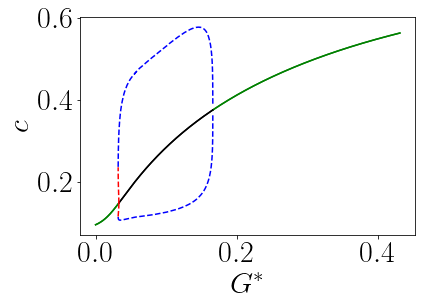

In [4]:
plot_bifurcation('Gstar_v3k_0.1_kd_0.7.dat')
plt.xlabel('$G^*$')
plt.ylabel('$c$')
plt.savefig('figures/c_Gstar_bifurcation.png', bbox_inches='tight')

## v_3k, k_d plots

Here we are modifying the Ca2+ -> IP3 negative feedback parameters v_3k (strength) and k_d (half-max). Increases to k_d seems to widen the range of c values taken during oscillations, but unsurprisingly, beyond $k_d \geq 1.5$, it seems to have no further impact as calcium never reaches much beyond this range. Larger v_3k seems to have an opposite effect, constraining the oscillations to a small c range, perhaps because the oscillations are being cut short by the strong feedback.

We have also plotted the period of the oscillation at when Gstar is at half the value of the two Hopf bifurcation Gstar levels

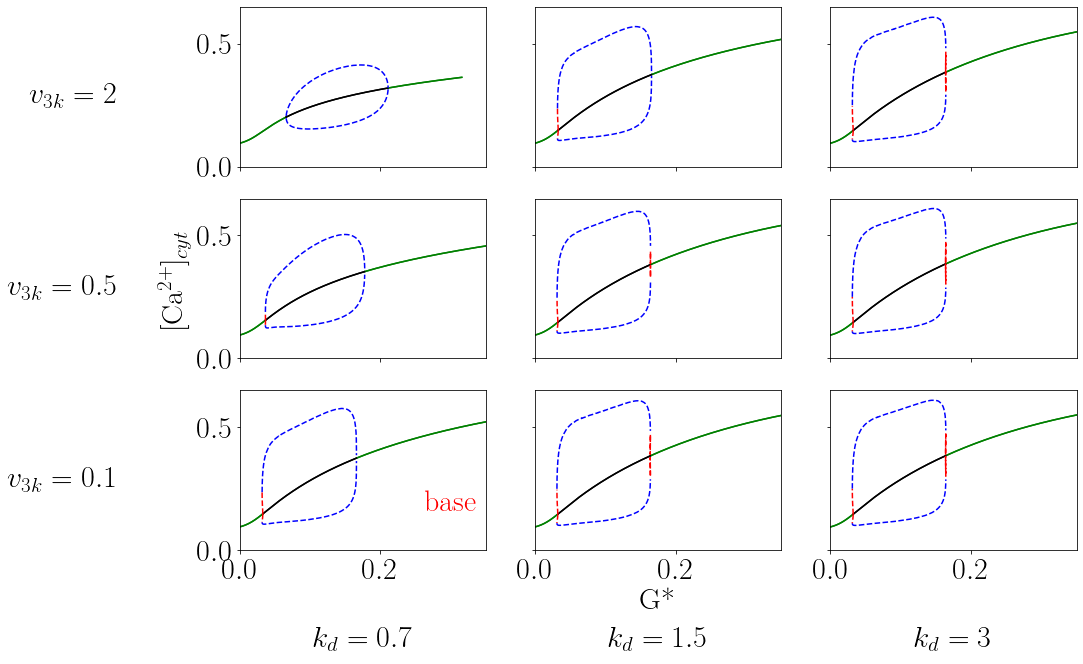

In [222]:
v_3ks = [2, 0.5, 0.1]
k_ds = [0.7, 1.5, 3]

fig, ax = plt.subplots(3, 3, figsize=(15,10), sharex=True, sharey=True)
# plot_bifurcation('Gstar_v3k_2.dat', ax[0])
# plot_bifurcation('Gstar_v3k_0.5.dat', ax[1])
# plot_bifurcation('Gstar_base.dat', ax[2])

for i, v3k in enumerate(v_3ks):
    for j, kd in enumerate(k_ds):
        filename = 'Gstar_v3k_' + str(v3k) + '_kd_' + str(kd) + '.dat'
        plot_bifurcation(filename, ax[i, j])
        
ax[2, 0].set_xlim([0, 0.35])
ax[2, 0].set_ylim([0, 0.65])

for i, v3k in enumerate(v_3ks):
    ax[i, 0].text(-0.5, 0.5, r'$v_{3k} = ' + str(v3k) + '$', horizontalalignment='right', 
                  verticalalignment='top', transform=ax[i, 0].transAxes)
for j, kd in enumerate(k_ds):
    ax[2, j].text(0.5, -0.5, r'$k_d = ' + str(kd) + '$', horizontalalignment='center', 
                  verticalalignment='top', transform=ax[2, j].transAxes)
    
ax[2, 0].text(0.75, 0.25, 'base', transform=ax[2, 0].transAxes, color='red')
ax[1, 0].set_ylabel(r'[Ca$^{2+}$]$_{cyt}$')
ax[2, 1].set_xlabel(r'G*')

fig.savefig('figures/v3k_kd_bifurcations.png', bbox_inches='tight')

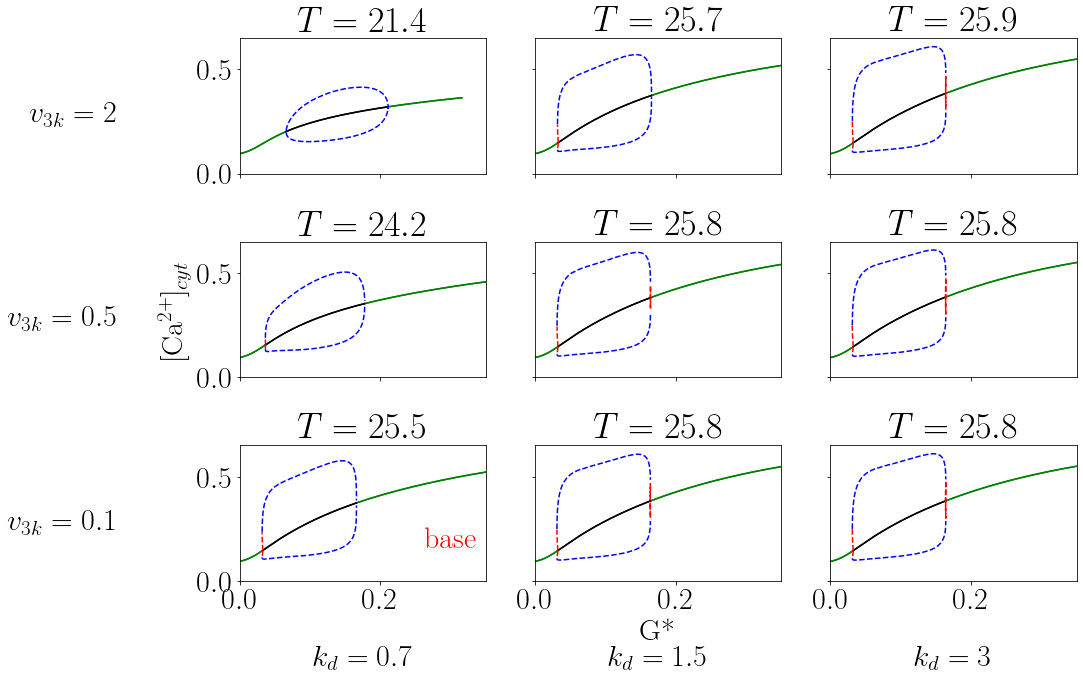

In [34]:
v_3ks = [2, 0.5, 0.1]
k_ds = [0.7, 1.5, 3]

fig, ax = plt.subplots(3, 3, figsize=(15,10), sharex=True, sharey=True, )

for i, v3k in enumerate(v_3ks):
    for j, kd in enumerate(k_ds):
        filename = 'Gstar_v3k_' + str(v3k) + '_kd_' + str(kd) + '.dat'
        data = plot_bifurcation(filename, ax[i, j], ret=True)
        
        #get oscillation period at half oscillation max
        d = data[data[3] == 3]
        input_max = (d[0].max() + d[0].min()) / 2

        run_Gstar_controlled_experiment('pulse')

        peak_times = t[scipy.signal.find_peaks(c)[0]]
        peak_times = peak_times[peak_times > 700]
        period = np.diff(peak_times)[-1]
        
        ax[i, j].set_title(r'$T = ' + str(round(period, 1)) + '$')
        
ax[2, 0].set_xlim([0, 0.35])
ax[2, 0].set_ylim([0, 0.65])

for i, v3k in enumerate(v_3ks):
    ax[i, 0].text(-0.5, 0.5, r'$v_{3k} = ' + str(v3k) + '$', horizontalalignment='right', 
                  verticalalignment='top', transform=ax[i, 0].transAxes)
for j, kd in enumerate(k_ds):
    ax[2, j].text(0.5, -0.5, r'$k_d = ' + str(kd) + '$', horizontalalignment='center', 
                  verticalalignment='top', transform=ax[2, j].transAxes)
    
ax[2, 0].text(0.75, 0.25, 'base', transform=ax[2, 0].transAxes, color='red')
ax[1, 0].set_ylabel(r'[Ca$^{2+}$]$_{cyt}$')
ax[2, 1].set_xlabel(r'G*')

fig.subplots_adjust(hspace=0.5)

fig.savefig('figures/v3k_kd_bifurcations_period.png', bbox_inches='tight')

### Checking v_3k, k_d combinations

Just wanted to check here how the plots respond

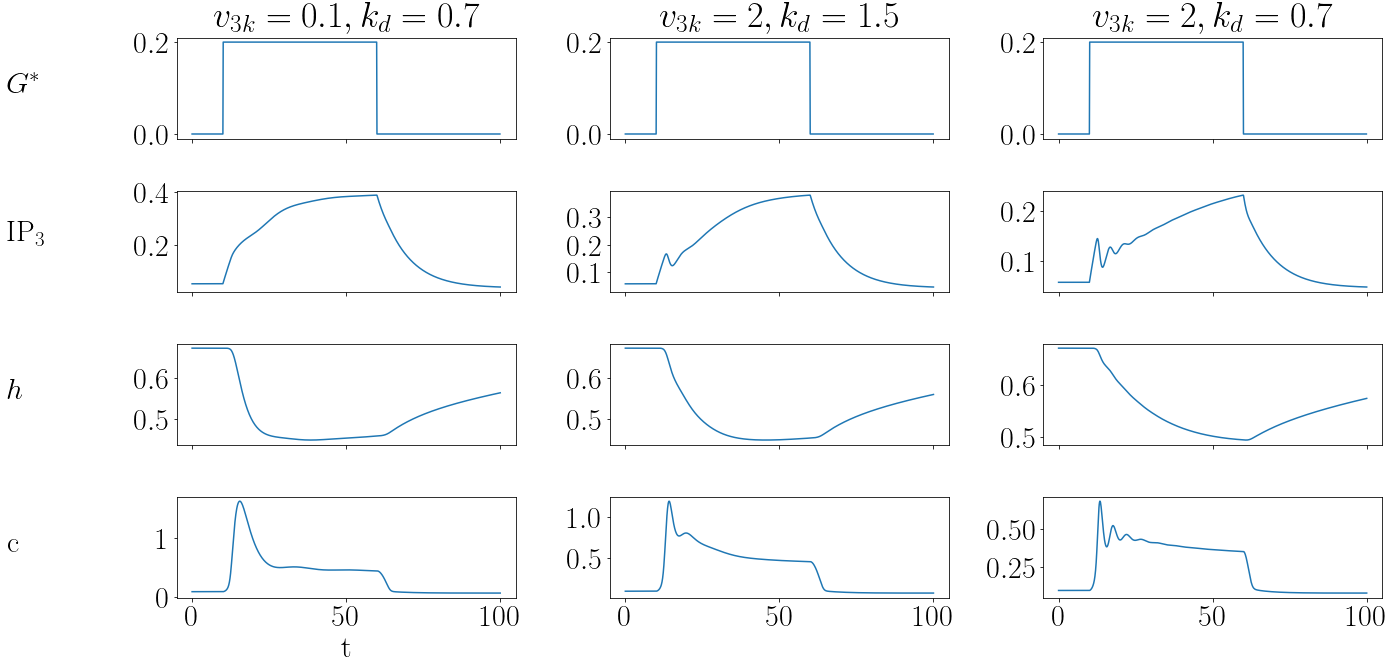

In [48]:
input_duration = 50
input_max = 0.2
t_f = 100

fig, ax = plt.subplots(4, 3, sharex=True, figsize=(20, 10))

v_3k = 0.1
k_d = 0.7
run_Gstar_controlled_experiment('pulse', t_f=t_f)

#plot figures
ax[0, 0].plot(t_input, Gstar)
ax[1, 0].plot(t, p)
ax[2, 0].plot(t, h)
ax[3, 0].plot(t, c)

ax[0, 0].set_title(r'$v_{3k} = 0.1, k_d = 0.7$')


v_3k = 2
k_d = 1.5
run_Gstar_controlled_experiment('pulse', t_f=t_f)

#plot figures
ax[0, 1].plot(t_input, Gstar)
ax[1, 1].plot(t, p)
ax[2, 1].plot(t, h)
ax[3, 1].plot(t, c)

ax[0, 1].set_title(r'$v_{3k} = 2, k_d = 1.5$')



v_3k = 2
k_d = 0.7
run_Gstar_controlled_experiment('pulse', t_f=t_f)

#plot figures
ax[0, 2].plot(t_input, Gstar)
ax[1, 2].plot(t, p)
ax[2, 2].plot(t, h)
ax[3, 2].plot(t, c)

ax[0, 2].set_title(r'$v_{3k} = 2, k_d = 0.7$')


#set xlabel
ax[3, 0].set_xlabel('t')

#set ylabels
ax[0, 0].set_ylabel(r'$G^*$', rotation='horizontal', ha='left')
ax[1, 0].set_ylabel(r'IP$_3$', rotation='horizontal', ha='left')
ax[2, 0].set_ylabel(r'$h$', rotation='horizontal', ha='left')
ax[3, 0].set_ylabel(r'c', rotation='horizontal', ha='left')

#align ylabels
ax[0, 0].get_yaxis().set_label_coords(-0.5,0.4)
ax[1, 0].get_yaxis().set_label_coords(-0.5,0.4)
ax[2, 0].get_yaxis().set_label_coords(-0.5,0.4)
ax[3, 0].get_yaxis().set_label_coords(-0.5,0.4)

fig.tight_layout()

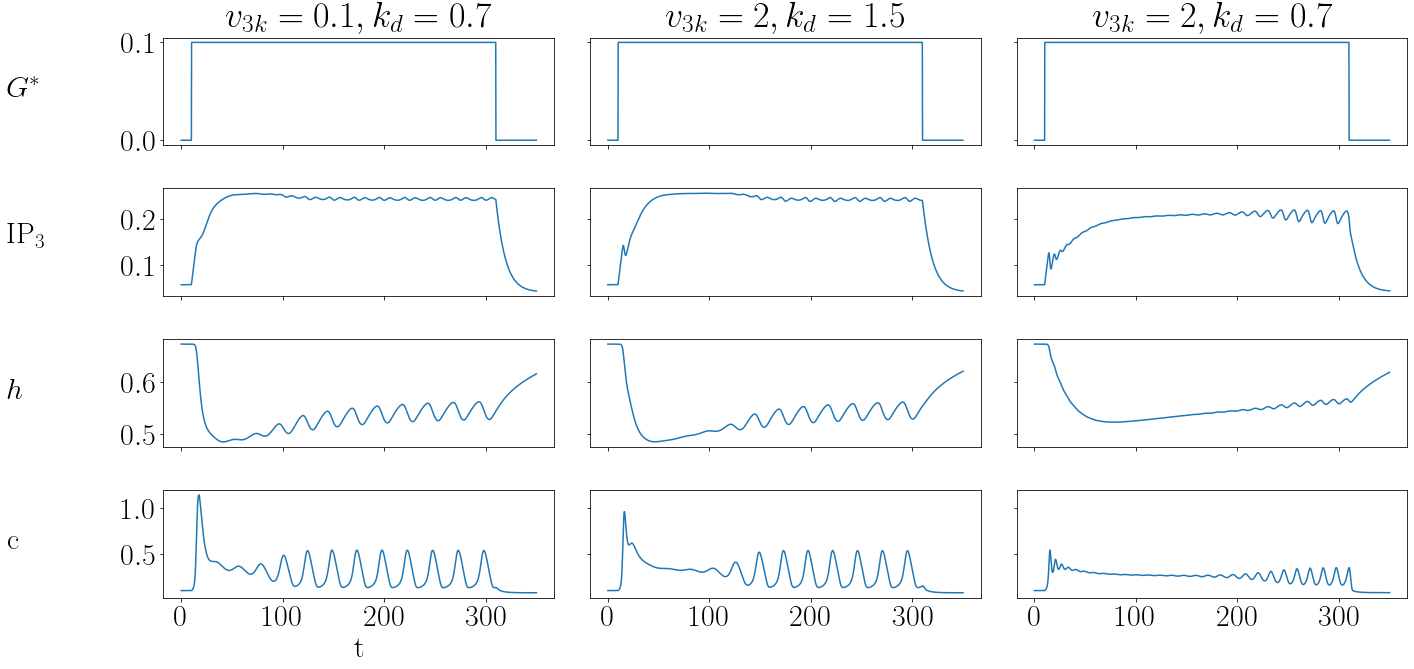

In [5]:
input_duration = 300
input_max = 0.1
t_f = 350

fig, ax = plt.subplots(4, 3, sharex=True, sharey='row', figsize=(20, 10))

v_3k = 0.1
k_d = 0.7
run_Gstar_controlled_experiment('pulse', t_f=t_f)

#plot figures
ax[0, 0].plot(t_input, Gstar)
ax[1, 0].plot(t, p)
ax[2, 0].plot(t, h)
ax[3, 0].plot(t, c)

ax[0, 0].set_title(r'$v_{3k} = 0.1, k_d = 0.7$')


v_3k = 2
k_d = 1.5
run_Gstar_controlled_experiment('pulse', t_f=t_f)

#plot figures
ax[0, 1].plot(t_input, Gstar)
ax[1, 1].plot(t, p)
ax[2, 1].plot(t, h)
ax[3, 1].plot(t, c)

ax[0, 1].set_title(r'$v_{3k} = 2, k_d = 1.5$')


v_3k = 2
k_d = 0.7
run_Gstar_controlled_experiment('pulse', t_f=t_f)

#plot figures
ax[0, 2].plot(t_input, Gstar)
ax[1, 2].plot(t, p)
ax[2, 2].plot(t, h)
ax[3, 2].plot(t, c)

ax[0, 2].set_title(r'$v_{3k} = 2, k_d = 0.7$')


#set xlabel
ax[3, 0].set_xlabel('t')

#set ylabels
ax[0, 0].set_ylabel(r'$G^*$', rotation='horizontal', ha='left')
ax[1, 0].set_ylabel(r'IP$_3$', rotation='horizontal', ha='left')
ax[2, 0].set_ylabel(r'$h$', rotation='horizontal', ha='left')
ax[3, 0].set_ylabel(r'c', rotation='horizontal', ha='left')

#align ylabels
ax[0, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[1, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[2, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[3, 0].get_yaxis().set_label_coords(-0.4,0.4)

fig.tight_layout()
fig.savefig('figures/ca2_ip3_negative_feedback_delays/negative_strength_variations.png', bbox_inches='tight')

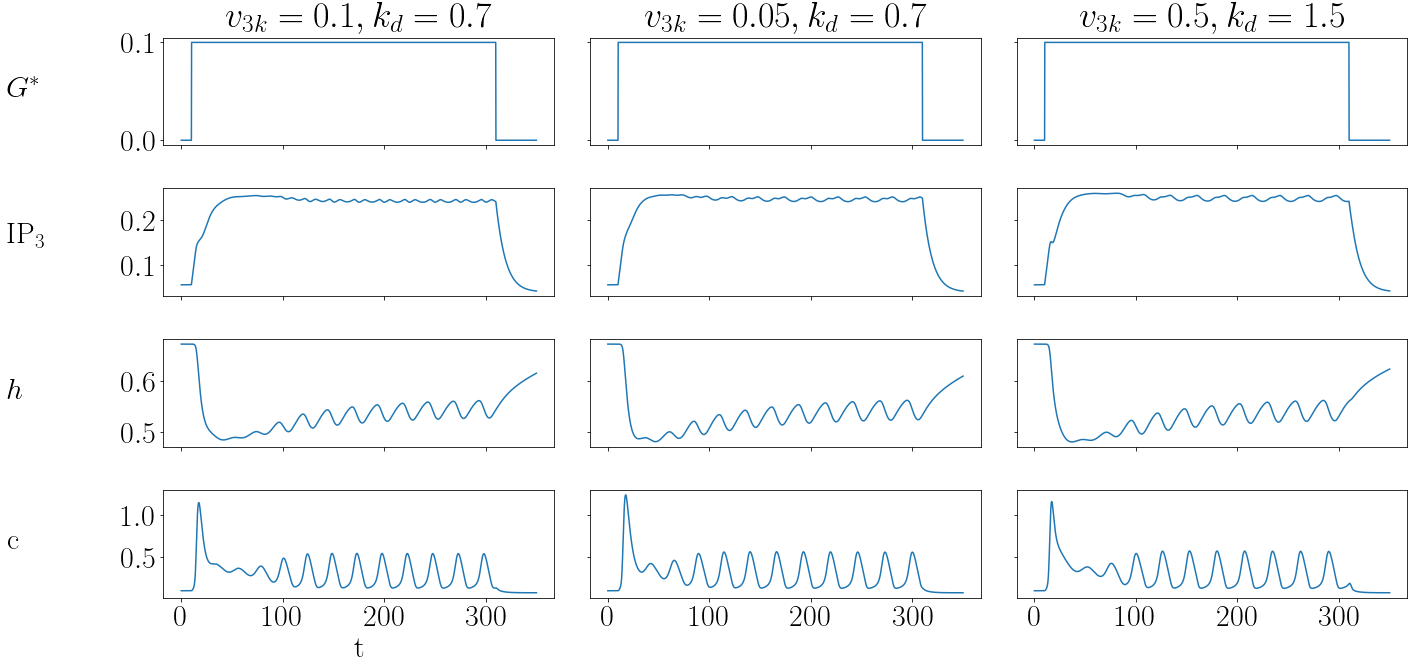

In [4]:
input_duration = 300
input_max = 0.1
t_f = 350

fig, ax = plt.subplots(4, 3, sharex=True, sharey='row', figsize=(20, 10))

v_3k = 0.1
k_d = 0.7
run_Gstar_controlled_experiment('pulse', t_f=t_f)

#plot figures
ax[0, 0].plot(t_input, Gstar)
ax[1, 0].plot(t, p)
ax[2, 0].plot(t, h)
ax[3, 0].plot(t, c)

ax[0, 0].set_title(r'$v_{3k} = 0.1, k_d = 0.7$')


v_3k = 0.05
k_d = 0.7
run_Gstar_controlled_experiment('pulse', t_f=t_f)

#plot figures
ax[0, 1].plot(t_input, Gstar)
ax[1, 1].plot(t, p)
ax[2, 1].plot(t, h)
ax[3, 1].plot(t, c)

ax[0, 1].set_title(r'$v_{3k} = 0.05, k_d = 0.7$')


v_3k = 0.5
k_d = 1.5
run_Gstar_controlled_experiment('pulse', t_f=t_f)

#plot figures
ax[0, 2].plot(t_input, Gstar)
ax[1, 2].plot(t, p)
ax[2, 2].plot(t, h)
ax[3, 2].plot(t, c)

ax[0, 2].set_title(r'$v_{3k} = 0.5, k_d = 1.5$')


#set xlabel
ax[3, 0].set_xlabel('t')

#set ylabels
ax[0, 0].set_ylabel(r'$G^*$', rotation='horizontal', ha='left')
ax[1, 0].set_ylabel(r'IP$_3$', rotation='horizontal', ha='left')
ax[2, 0].set_ylabel(r'$h$', rotation='horizontal', ha='left')
ax[3, 0].set_ylabel(r'c', rotation='horizontal', ha='left')

#align ylabels
ax[0, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[1, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[2, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[3, 0].get_yaxis().set_label_coords(-0.4,0.4)

fig.tight_layout()

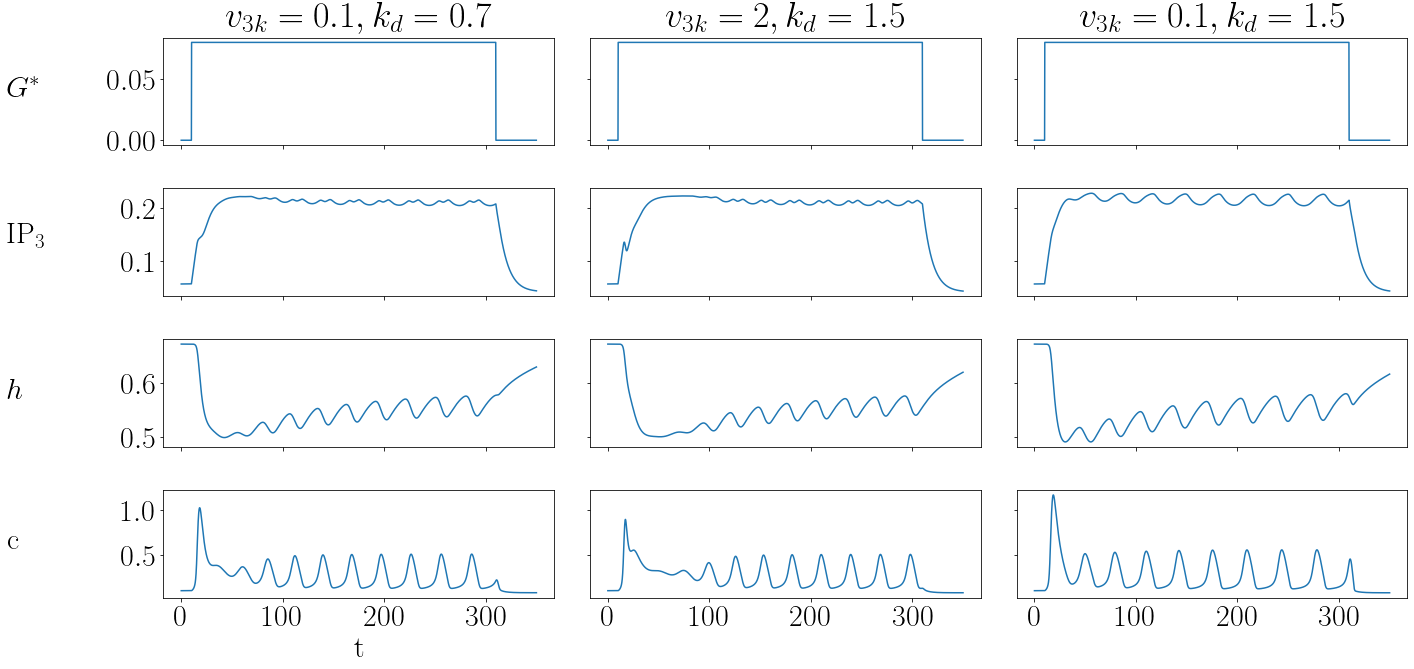

In [79]:
input_duration = 300
input_max = 0.08
t_f = 350

fig, ax = plt.subplots(4, 3, sharex=True, sharey='row', figsize=(20, 10))

v_3k = 0.1
k_d = 0.7
run_Gstar_controlled_experiment('pulse', t_f=t_f)

#plot figures
ax[0, 0].plot(t_input, Gstar)
ax[1, 0].plot(t, p)
ax[2, 0].plot(t, h)
ax[3, 0].plot(t, c)

ax[0, 0].set_title(r'$v_{3k} = 0.1, k_d = 0.7$')


v_3k = 2
k_d = 1.5
run_Gstar_controlled_experiment('pulse', t_f=t_f)

#plot figures
ax[0, 1].plot(t_input, Gstar)
ax[1, 1].plot(t, p)
ax[2, 1].plot(t, h)
ax[3, 1].plot(t, c)

ax[0, 1].set_title(r'$v_{3k} = 2, k_d = 1.5$')


v_3k = 0.1
k_d = 1.5
run_Gstar_controlled_experiment('pulse', t_f=t_f)

#plot figures
ax[0, 2].plot(t_input, Gstar)
ax[1, 2].plot(t, p)
ax[2, 2].plot(t, h)
ax[3, 2].plot(t, c)

ax[0, 2].set_title(r'$v_{3k} = 0.1, k_d = 1.5$')


#set xlabel
ax[3, 0].set_xlabel('t')

#set ylabels
ax[0, 0].set_ylabel(r'$G^*$', rotation='horizontal', ha='left')
ax[1, 0].set_ylabel(r'IP$_3$', rotation='horizontal', ha='left')
ax[2, 0].set_ylabel(r'$h$', rotation='horizontal', ha='left')
ax[3, 0].set_ylabel(r'c', rotation='horizontal', ha='left')

#align ylabels
ax[0, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[1, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[2, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[3, 0].get_yaxis().set_label_coords(-0.4,0.4)

fig.tight_layout()

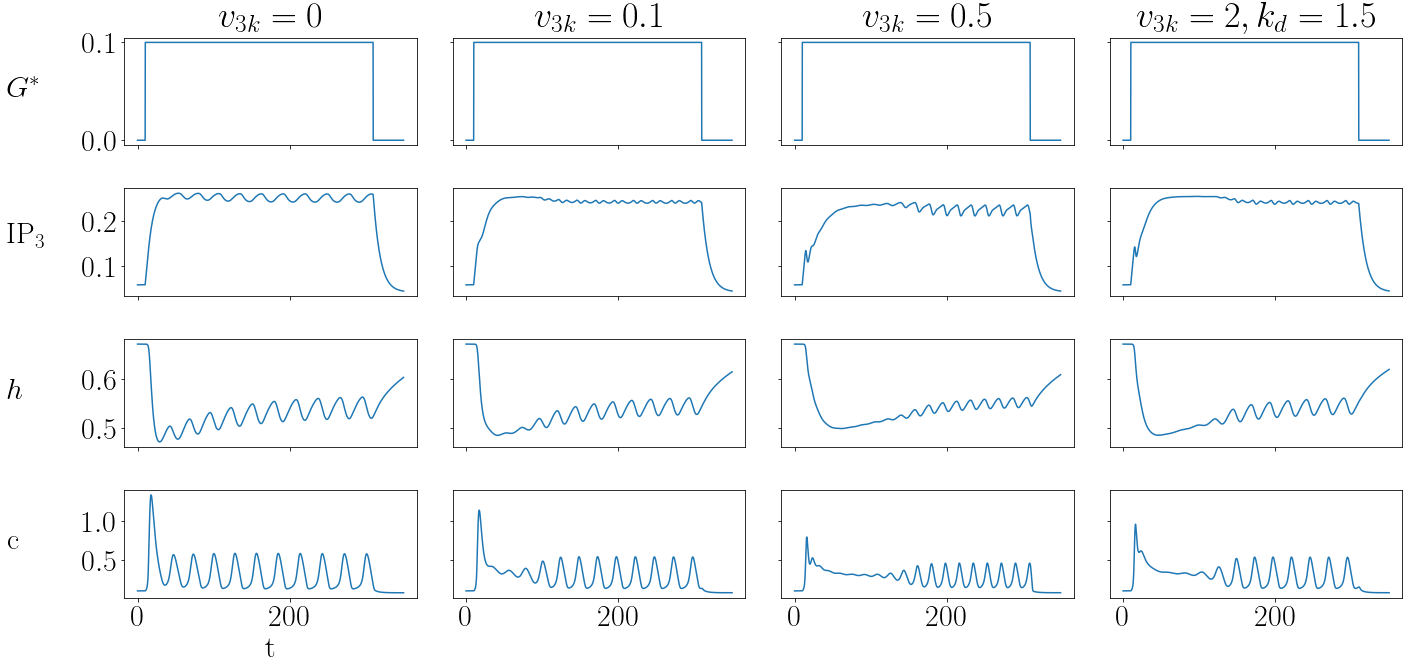

In [10]:
cfg.input_duration = 300
cfg.input_max = 0.1
cfg.t_f = 350
t_f = cfg.t_f

fig, ax = plt.subplots(4, 4, sharex=True, sharey='row', figsize=(20, 10))

cfg.v_3k = 0
run_Gstar_controlled_experiment('pulse', t_f=t_f)

#plot figures
ax[0, 0].plot(cfg.t_input, cfg.Gstar)
ax[1, 0].plot(cfg.t, cfg.p)
ax[2, 0].plot(cfg.t, cfg.h)
ax[3, 0].plot(cfg.t, cfg.c)

ax[0, 0].set_title(r'$v_{3k} = 0$')


cfg.v_3k = 0.1
run_Gstar_controlled_experiment('pulse', t_f=t_f)

#plot figures
ax[0, 1].plot(cfg.t_input, cfg.Gstar)
ax[1, 1].plot(cfg.t, cfg.p)
ax[2, 1].plot(cfg.t, cfg.h)
ax[3, 1].plot(cfg.t, cfg.c)

ax[0, 1].set_title(r'$v_{3k} = 0.1$')


cfg.v_3k = 0.5
run_Gstar_controlled_experiment('pulse', t_f=t_f)

#plot figures
ax[0, 2].plot(cfg.t_input, cfg.Gstar)
ax[1, 2].plot(cfg.t, cfg.p)
ax[2, 2].plot(cfg.t, cfg.h)
ax[3, 2].plot(cfg.t, cfg.c)

ax[0, 2].set_title(r'$v_{3k} = 0.5$')


cfg.v_3k = 2
cfg.k_d = 1.5
run_Gstar_controlled_experiment('pulse', t_f=t_f)

#plot figures
ax[0, 3].plot(cfg.t_input, cfg.Gstar)
ax[1, 3].plot(cfg.t, cfg.p)
ax[2, 3].plot(cfg.t, cfg.h)
ax[3, 3].plot(cfg.t, cfg.c)

ax[0, 3].set_title(r'$v_{3k} = 2, k_d=1.5$')


#set xlabel
ax[3, 0].set_xlabel('t')

#set ylabels
ax[0, 0].set_ylabel(r'$G^*$', rotation='horizontal', ha='left')
ax[1, 0].set_ylabel(r'IP$_3$', rotation='horizontal', ha='left')
ax[2, 0].set_ylabel(r'$h$', rotation='horizontal', ha='left')
ax[3, 0].set_ylabel(r'c', rotation='horizontal', ha='left')

#align ylabels
ax[0, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[1, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[2, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[3, 0].get_yaxis().set_label_coords(-0.4,0.4)

fig.tight_layout()
fig.savefig('figures/ca2_ip3_negative_feedback_delays/varying_v3k.png', bbox_inches='tight')

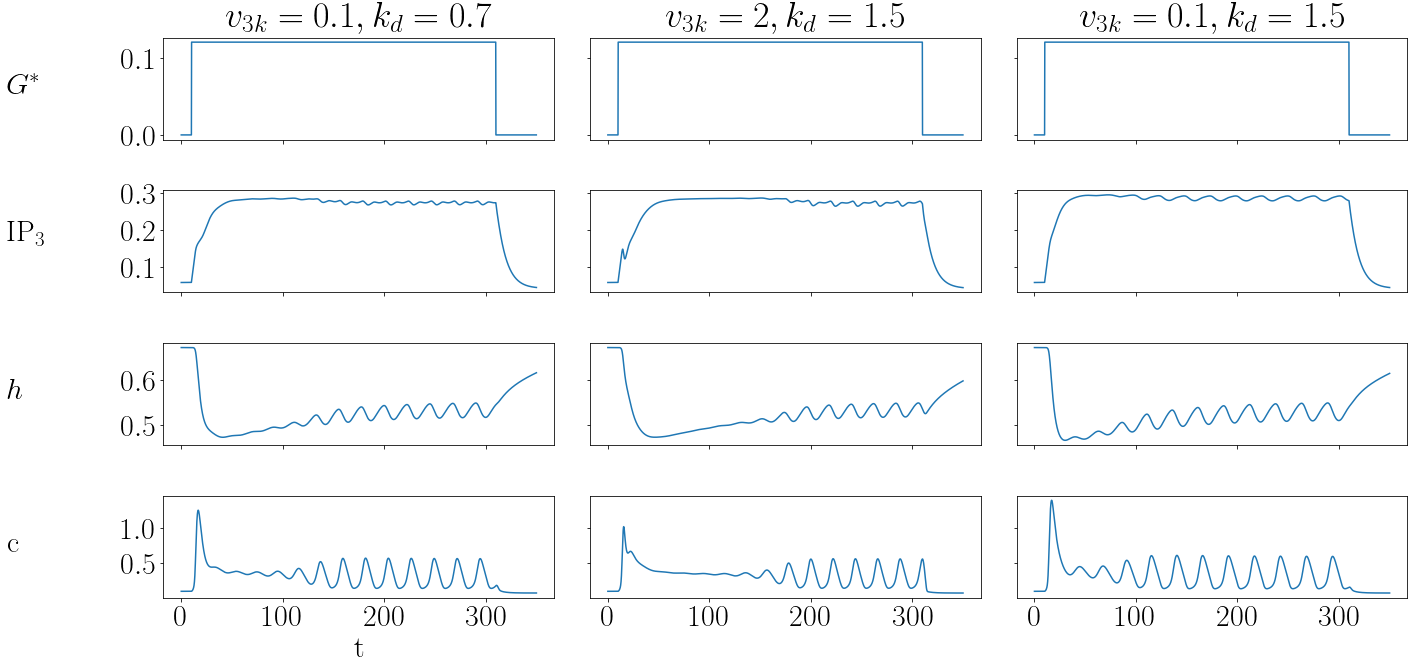

In [80]:
input_duration = 300
input_max = 0.12
t_f = 350

fig, ax = plt.subplots(4, 3, sharex=True, sharey='row', figsize=(20, 10))

v_3k = 0.1
k_d = 0.7
run_Gstar_controlled_experiment('pulse', t_f=t_f)

#plot figures
ax[0, 0].plot(t_input, Gstar)
ax[1, 0].plot(t, p)
ax[2, 0].plot(t, h)
ax[3, 0].plot(t, c)

ax[0, 0].set_title(r'$v_{3k} = 0.1, k_d = 0.7$')


v_3k = 2
k_d = 1.5
run_Gstar_controlled_experiment('pulse', t_f=t_f)

#plot figures
ax[0, 1].plot(t_input, Gstar)
ax[1, 1].plot(t, p)
ax[2, 1].plot(t, h)
ax[3, 1].plot(t, c)

ax[0, 1].set_title(r'$v_{3k} = 2, k_d = 1.5$')


v_3k = 0.1
k_d = 1.5
run_Gstar_controlled_experiment('pulse', t_f=t_f)

#plot figures
ax[0, 2].plot(t_input, Gstar)
ax[1, 2].plot(t, p)
ax[2, 2].plot(t, h)
ax[3, 2].plot(t, c)

ax[0, 2].set_title(r'$v_{3k} = 0.1, k_d = 1.5$')


#set xlabel
ax[3, 0].set_xlabel('t')

#set ylabels
ax[0, 0].set_ylabel(r'$G^*$', rotation='horizontal', ha='left')
ax[1, 0].set_ylabel(r'IP$_3$', rotation='horizontal', ha='left')
ax[2, 0].set_ylabel(r'$h$', rotation='horizontal', ha='left')
ax[3, 0].set_ylabel(r'c', rotation='horizontal', ha='left')

#align ylabels
ax[0, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[1, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[2, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[3, 0].get_yaxis().set_label_coords(-0.4,0.4)

fig.tight_layout()

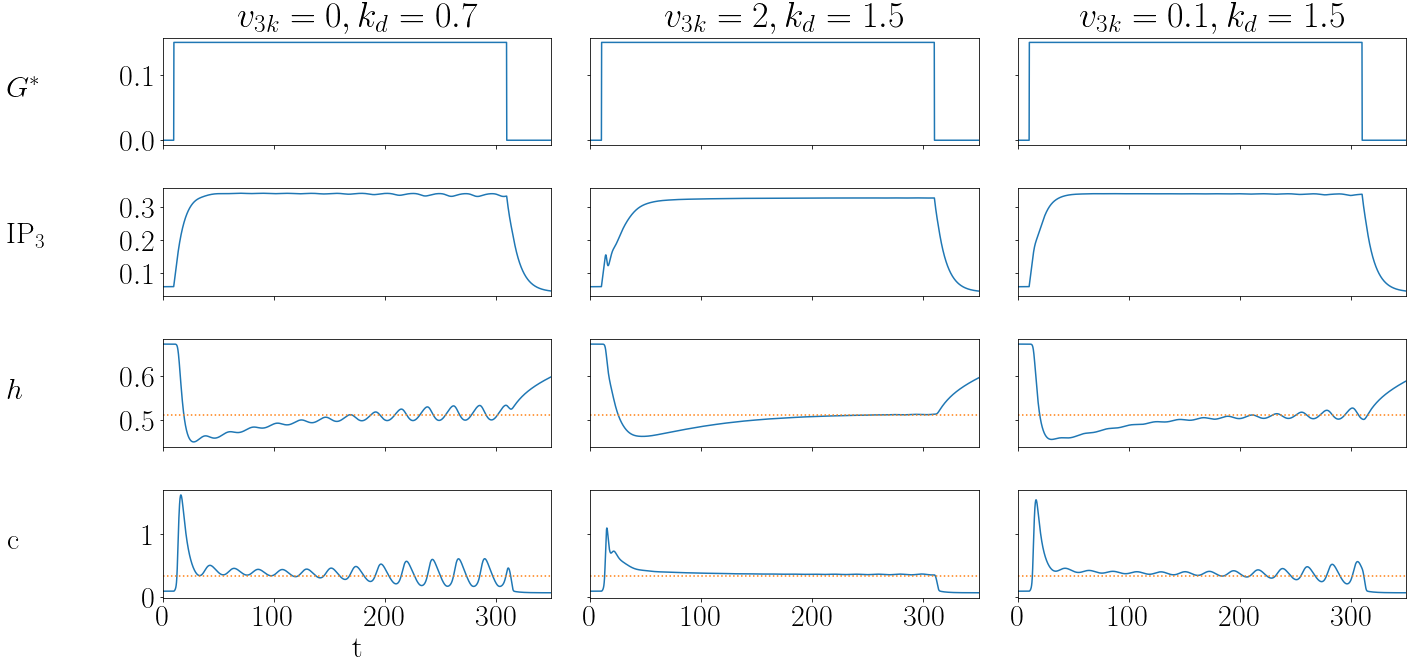

In [29]:
input_duration = 300
input_max = 0.15
t_f = 350

fig, ax = plt.subplots(4, 3, sharex=True, sharey='row', figsize=(20, 10))

v_3k = 0
k_d = 0.7
run_Gstar_controlled_experiment('pulse', t_f=t_f)

#plot figures
ax[0, 0].plot(t_input, Gstar)
ax[1, 0].plot(t, p)
ax[2, 0].plot(t, h)
ax[3, 0].plot(t, c)

ax[0, 0].set_title(r'$v_{3k} = 0, k_d = 0.7$')


v_3k = 2
k_d = 1.5
run_Gstar_controlled_experiment('pulse', t_f=t_f)

#plot figures
ax[0, 1].plot(t_input, Gstar)
ax[1, 1].plot(t, p)
ax[2, 1].plot(t, h)
ax[3, 1].plot(t, c)

ax[0, 1].set_title(r'$v_{3k} = 2, k_d = 1.5$')


v_3k = 0.1
k_d = 1.5
run_Gstar_controlled_experiment('pulse', t_f=t_f)

#plot figures
ax[0, 2].plot(t_input, Gstar)
ax[1, 2].plot(t, p)
ax[2, 2].plot(t, h)
ax[3, 2].plot(t, c)

ax[0, 2].set_title(r'$v_{3k} = 0.1, k_d = 1.5$')


for i in range(3):
    ax[3, i].plot([0, 1000], [0.33, 0.33], ':') #plot dotted line on c
    ax[2, i].plot([0, 1000], [0.51, 0.51], ':')
ax[3, 0].set_xlim([0, t_f])

#set xlabel
ax[3, 0].set_xlabel('t')

#set ylabels
ax[0, 0].set_ylabel(r'$G^*$', rotation='horizontal', ha='left')
ax[1, 0].set_ylabel(r'IP$_3$', rotation='horizontal', ha='left')
ax[2, 0].set_ylabel(r'$h$', rotation='horizontal', ha='left')
ax[3, 0].set_ylabel(r'c', rotation='horizontal', ha='left')

#align ylabels
ax[0, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[1, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[2, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[3, 0].get_yaxis().set_label_coords(-0.4,0.4)

fig.tight_layout()

## v_delta, k_plcdelta plots

Here we are modifying the Ca2+ -> IP3 positive feedback parameters v_delta (strength) and k_plcdelta (half-max). 

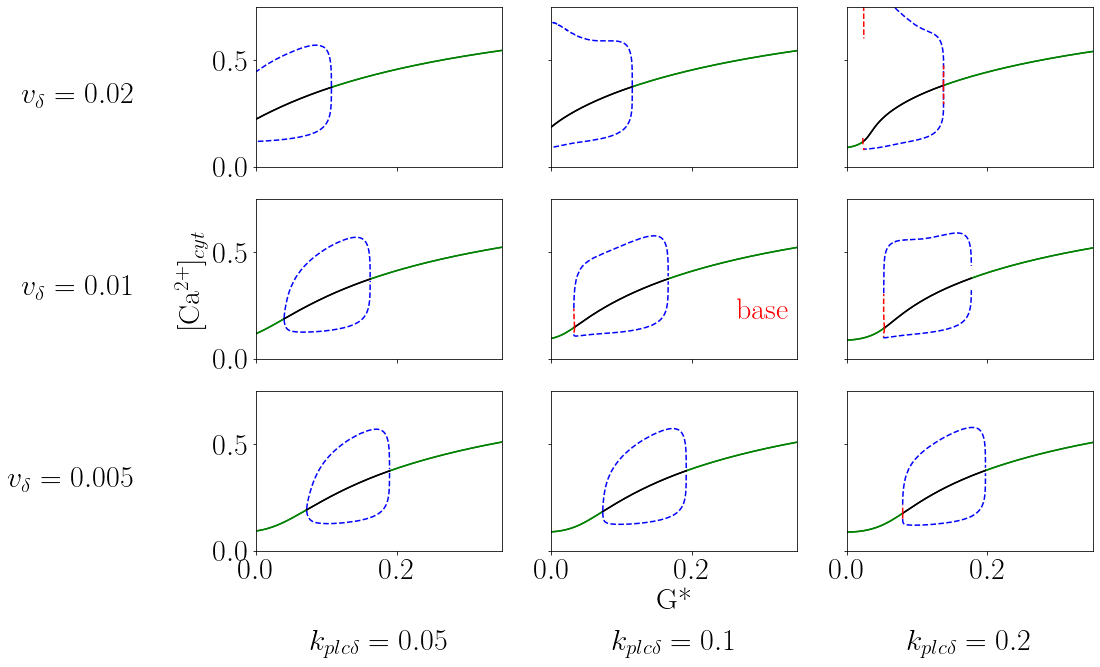

In [72]:
v_deltas = [0.02, 0.01, 0.005]
k_plcdeltas = [0.05, 0.1, 0.2]

fig, ax = plt.subplots(3, 3, figsize=(15,10), sharex=True, sharey=True)

for i, vdelta in enumerate(v_deltas):
    for j, kplcdelta in enumerate(k_plcdeltas):
        filename = 'Gstar_vdelta_' + str(vdelta) + '_kplcdelta_' + str(kplcdelta) + '.dat'
        plot_bifurcation(filename, ax[i, j])
        
ax[2, 0].set_xlim([0, 0.35])
ax[2, 0].set_ylim([0, 0.75])

for i, vdelta in enumerate(v_deltas):
    ax[i, 0].text(-0.5, 0.5, r'$v_{\delta} = ' + str(vdelta) + '$', horizontalalignment='right', 
                  verticalalignment='top', transform=ax[i, 0].transAxes)
for j, kplcdelta in enumerate(k_plcdeltas):
    ax[2, j].text(0.5, -0.5, r'$k_{plc\delta} = ' + str(kplcdelta) + '$', horizontalalignment='center', 
                  verticalalignment='top', transform=ax[2, j].transAxes)
    
ax[1, 1].text(0.75, 0.25, 'base', transform=ax[1, 1].transAxes, color='red')
ax[1, 0].set_ylabel(r'[Ca$^{2+}$]$_{cyt}$')
ax[2, 1].set_xlabel(r'G*')

fig.savefig('figures/vdelta_kplcdelta_bifurcations.png', bbox_inches='tight')

## Positive, Negative off

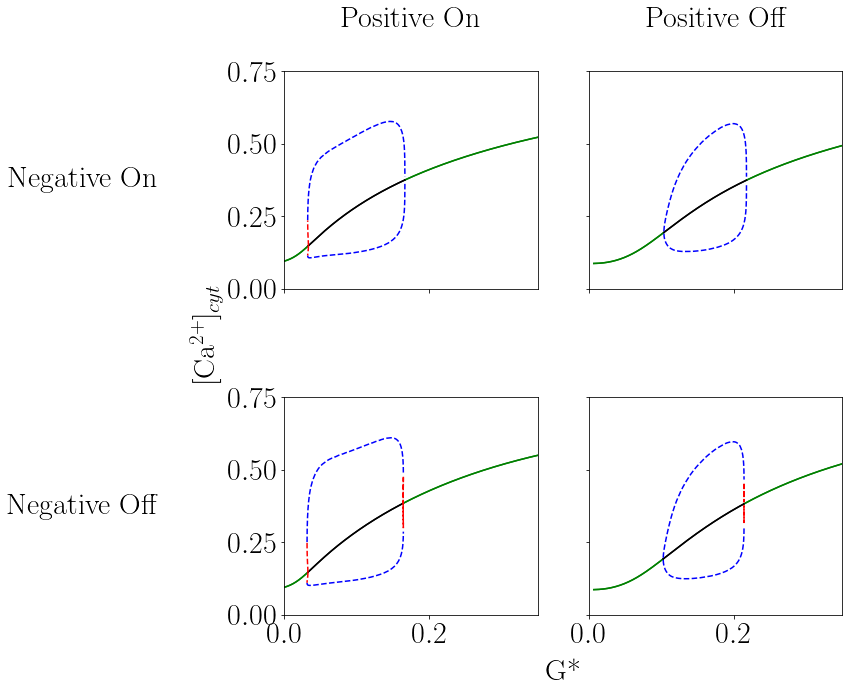

In [19]:
filenames = ['_v3k_0.1_kd_0.7', '_no_pos', '_no_neg', '_no_pos_no_neg']
titles = ['base', 'no +', 'no -', 'no +, no -']
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)


for i in range(2):
    for j in range(2):
        filename = filenames[i*2 + j]
        plot_bifurcation('Gstar' + filename + '.dat', ax[i, j])
        
ax[0, 0].text(0.5, 1.2, 'Positive On', horizontalalignment='center', transform=ax[0, 0].transAxes)
ax[0, 1].text(0.5, 1.2, 'Positive Off', horizontalalignment='center', transform=ax[0, 1].transAxes)

ax[0, 0].text(-0.5, 0.5, 'Negative On', 
          verticalalignment='center', horizontalalignment='right', transform=ax[0, 0].transAxes)
ax[1, 0].text(-0.5, 0.5, 'Negative Off', 
          verticalalignment='center', horizontalalignment='right', transform=ax[1, 0].transAxes)

ax[1, 0].text(1.1, -0.3, r'G*', horizontalalignment='center', transform=ax[1, 0].transAxes)
ax[1, 0].text(-0.3, 1.3, r'[Ca$^{2+}$]$_{cyt}$', rotation=90, transform=ax[1, 0].transAxes, 
              horizontalalignment='center', verticalalignment='center')

ax[0, 0].set_xlim([0, 0.35])
ax[0, 0].set_ylim([0, 0.75])


fig.subplots_adjust(hspace=0.5)
fig.savefig('figures/positive_negative_bifurcations.png', bbox_inches='tight')

# Nullcline exploration

Here we'll look at some nullclines and make some observations about what is going on

In this diagram, the pair of nullclines (red: p'=0, green: c'=0) on the left represent when G* is set to 0.07, and the pair on the right are when G* is set to 0.13.

Turning on G* moves only the red curve, preserving the shape but pushing it further to the right. As dynamics evolve, changes to other parameters move the green curve to have a less steep slope and move further to the right.

<img src="figures/Gstar_0.07_to_0.13_nc.png" width=600 />

Here we see the delay phenomenon a clearly, going from no Gstar to Gstar of 0.13. The trajectory is sent to the tip of the bulge in the red curve, where oscillations are much smaller, so we observe small oscillations that grow larger in c

<img src="figures/Gstar_0_to_0.13_nc.png" width=600 />

# Exploring parameter space with functions

In [17]:
def ip3_production(Gstar, c, p):
    return v_beta*Gstar + v_delta*((k_delta)/(1 + p))*((c**2)/(c**2 + k_plcdelta**2))
    
def ip3_degradation(c, p): 
    return v_3k*((c**4)/(c**4 + k_d**4))*(p/(p+k_3)) + r_5p*p

**IP3 Production Degradation with G*=0**

Text(0, 0.5, 'c')

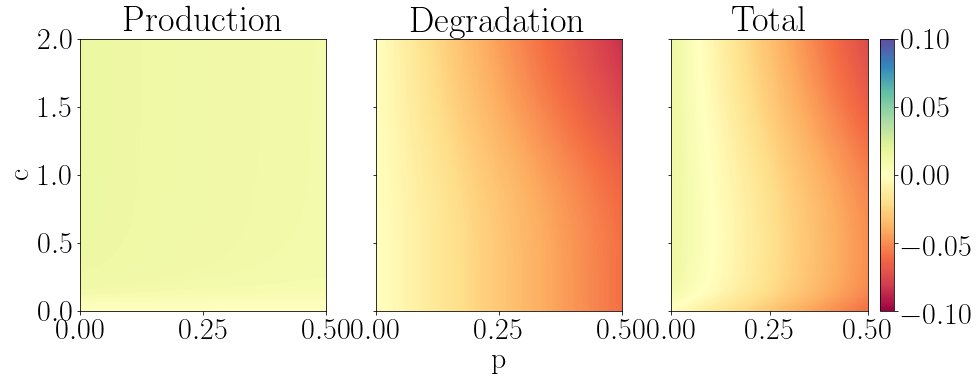

In [128]:
Gstar = 0
p, c = np.meshgrid(np.linspace(0, 0.5, 200), np.linspace(0, 2, 300))
p_prod = ip3_production(Gstar, c, p)
p_deg = ip3_degradation(c, p)

fig, ax = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(15, 5))

ax[0].pcolormesh(p, c, p_prod, cmap='Spectral', vmax=0.1, vmin=-0.1)
ax[1].pcolormesh(p, c, -p_deg, cmap='Spectral', vmax=0.1, vmin=-0.1)
cbar = ax[2].pcolormesh(p, c, p_prod - p_deg, cmap='Spectral', vmax=0.1, vmin=-0.1)

ax[0].set_title('Production')
ax[1].set_title('Degradation')
ax[2].set_title('Total')

fig.colorbar(cbar, ax=ax[2])

ax[1].set_xlabel('p')
ax[0].set_ylabel('c')

**IP3 Production Degradation with G*=0.1**

Text(0, 0.5, 'c')

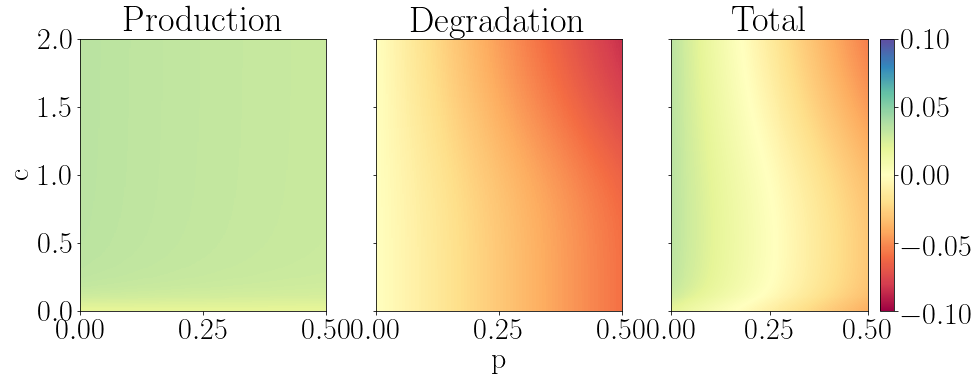

In [129]:
Gstar = 0.1
p, c = np.meshgrid(np.linspace(0, 0.5, 200), np.linspace(0, 2, 300))
p_prod = ip3_production(Gstar, c, p)
p_deg = ip3_degradation(c, p)

fig, ax = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(15, 5))

ax[0].pcolormesh(p, c, p_prod, cmap='Spectral', vmax=0.1, vmin=-0.1)
ax[1].pcolormesh(p, c, -p_deg, cmap='Spectral', vmax=0.1, vmin=-0.1)
cbar = ax[2].pcolormesh(p, c, p_prod - p_deg, cmap='Spectral', vmax=0.1, vmin=-0.1)

ax[0].set_title('Production')
ax[1].set_title('Degradation')
ax[2].set_title('Total')

fig.colorbar(cbar, ax=ax[2])

ax[1].set_xlabel('p')
ax[0].set_ylabel('c')

**IP3 Production Degradation with G*=0.13**

Text(0, 0.5, 'c')

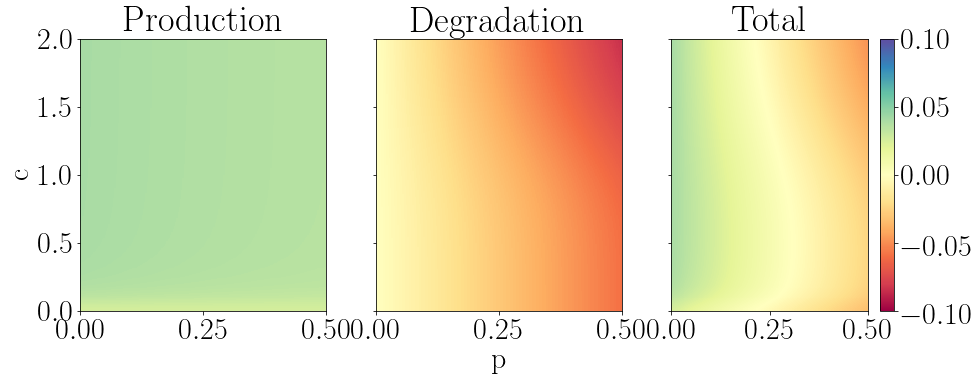

In [130]:
Gstar = 0.13
p, c = np.meshgrid(np.linspace(0, 0.5, 200), np.linspace(0, 2, 300))
p_prod = ip3_production(Gstar, c, p)
p_deg = ip3_degradation(c, p)

fig, ax = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(15, 5))

ax[0].pcolormesh(p, c, p_prod, cmap='Spectral', vmax=0.1, vmin=-0.1)
ax[1].pcolormesh(p, c, -p_deg, cmap='Spectral', vmax=0.1, vmin=-0.1)
cbar = ax[2].pcolormesh(p, c, p_prod - p_deg, cmap='Spectral', vmax=0.1, vmin=-0.1)

ax[0].set_title('Production')
ax[1].set_title('Degradation')
ax[2].set_title('Total')

fig.colorbar(cbar, ax=ax[2])

ax[1].set_xlabel('p')
ax[0].set_ylabel('c')

**IP3 Production Degradation with G*=0.13, v_3k=2**

Text(0, 0.5, 'c')

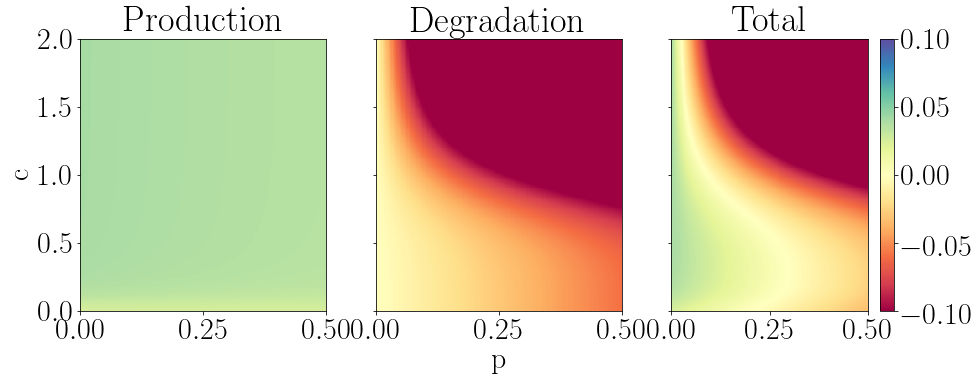

In [142]:
v_3k = 2
Gstar = 0.13
p, c = np.meshgrid(np.linspace(0, 0.5, 200), np.linspace(0, 2, 300))
p_prod = ip3_production(Gstar, c, p)
p_deg = ip3_degradation(c, p)

fig, ax = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(15, 5))

ax[0].pcolormesh(p, c, p_prod, cmap='Spectral', vmax=0.1, vmin=-0.1)
ax[1].pcolormesh(p, c, -p_deg, cmap='Spectral', vmax=0.1, vmin=-0.1)
cbar = ax[2].pcolormesh(p, c, p_prod - p_deg, cmap='Spectral', vmax=0.1, vmin=-0.1)

ax[0].set_title('Production')
ax[1].set_title('Degradation')
ax[2].set_title('Total')

fig.colorbar(cbar, ax=ax[2])

ax[1].set_xlabel('p')
ax[0].set_ylabel('c')

## Mapping Trajectories in p/c space showing IP3 production degradation

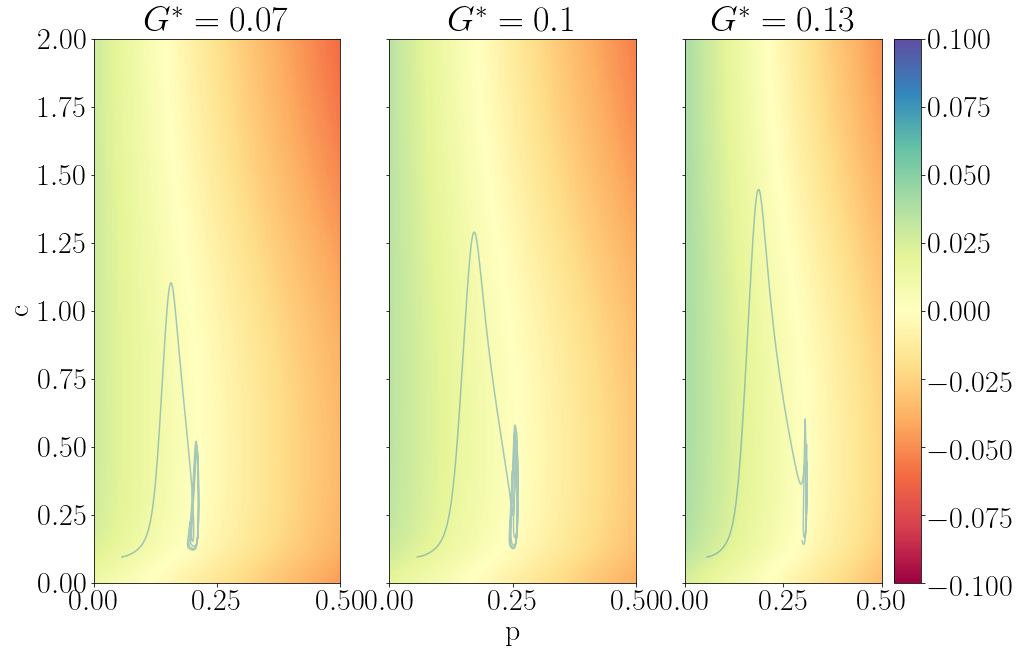

In [162]:
Gstars = [0.07, 0.10, 0.13]
input_max = 0.13
input_duration = 150
t_f = 150

fig, ax = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(15, 10))

for i, Gstar in enumerate(Gstars):
    input_max = Gstar
    p, c = np.meshgrid(np.linspace(0, 0.5, 200), np.linspace(0, 2, 300))
    p_prod = ip3_production(Gstar, c, p)
    p_deg = ip3_degradation(c, p)


    if(i == len(Gstars) - 1):
        cbar = ax[i].pcolormesh(p, c, p_prod - p_deg, cmap='Spectral', vmax=0.1, vmin=-0.1)
    else:
        ax[i].pcolormesh(p, c, p_prod - p_deg, cmap='Spectral', vmax=0.1, vmin=-0.1)

    run_Gstar_controlled_experiment('pulse', t_f=t_f)
    ax[i].plot(p, c, alpha=0.4)
    ax[i].set_title(r'$G^*=' + str(input_max) + '$')
fig.colorbar(cbar, ax=ax[len(Gstars) - 1])

ax[1].set_xlabel('p')
ax[0].set_ylabel('c')

input_max = 0.3
input_duration = 50
t_f = 1000

### v_3k set to 2, thickness shows how long solution spent in an area

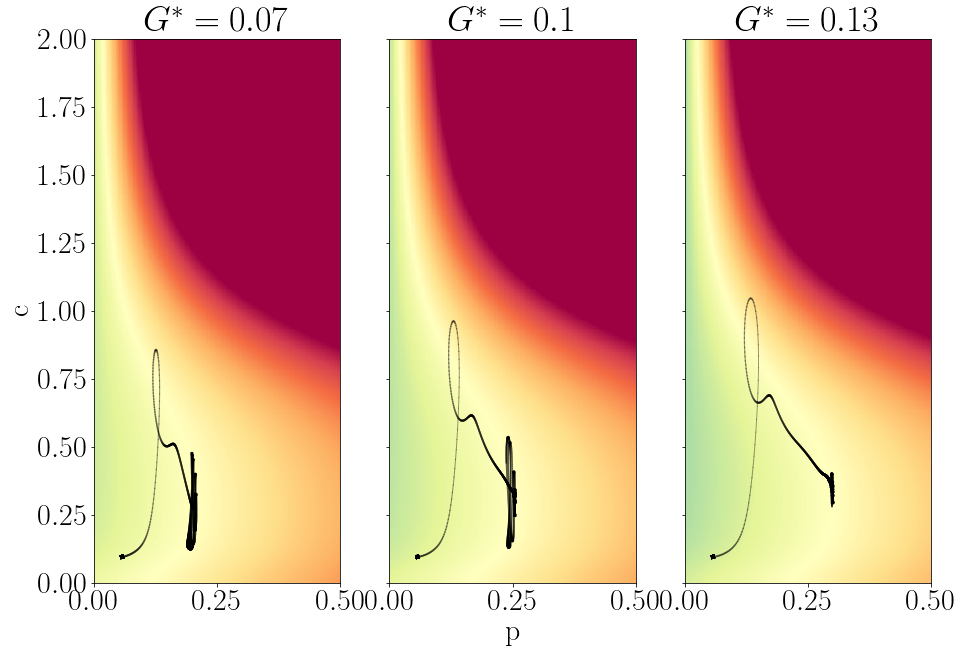

In [163]:
Gstars = [0.07, 0.10, 0.13]
input_max = 0.13
input_duration = 200
t_f = 200
v_3k = 2

fig, ax = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(15, 10))

for i, Gstar in enumerate(Gstars):
    input_max = Gstar
    p, c = np.meshgrid(np.linspace(0, 0.5, 200), np.linspace(0, 2, 300))
    p_prod = ip3_production(Gstar, c, p)
    p_deg = ip3_degradation(c, p)


    if(i == len(Gstars) - 1):
        cbar = ax[i].pcolormesh(p, c, p_prod - p_deg, cmap='Spectral', vmax=0.1, vmin=-0.1)
    else:
        ax[i].pcolormesh(p, c, p_prod - p_deg, cmap='Spectral', vmax=0.1, vmin=-0.1)

    run_Gstar_controlled_experiment('pulse', t_f=t_f)
    t_diffs = np.diff(t)
    distances = np.abs(np.log(np.sqrt(np.diff(p)**2 + np.diff(c)**2)))
    ax[i].set_title(r'$G^*=' + str(input_max) + '$')

    for j, size in enumerate(t_diffs):
#         print(size)
        ax[i].plot([p[j], p[j+1]], [c[j], c[j+1]], alpha=0.4, color='black', linewidth=size*3*distances[j])

# fig.colorbar(cbar, ax=ax[len(Gstars) - 1])

ax[1].set_xlabel('p')
ax[0].set_ylabel('c')

input_max = 0.3
input_duration = 50
t_f = 1000
v_3k = 0.1

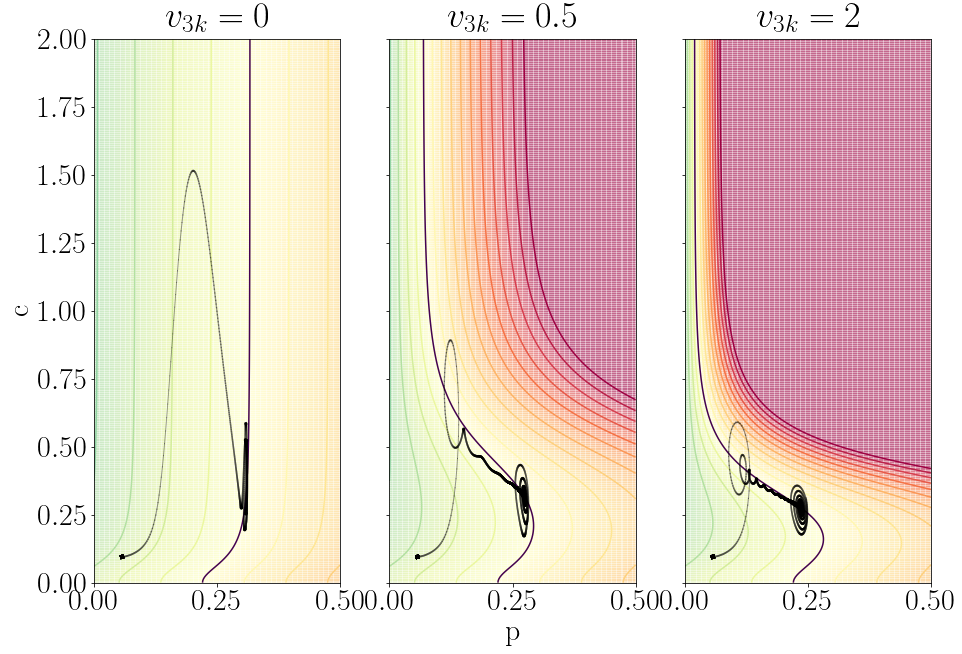

In [28]:
Gstars = [0.07, 0.10, 0.13]
input_max = 0.13
input_duration = 200
t_fs = [100, 250, 300]
v_3ks = [0, 0.5, 2]

fig, ax = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(15, 10))

for i, v_3k in enumerate(v_3ks):
    t_f = t_fs[i]
    input_duration=t_fs[i]
    p, c = np.meshgrid(np.linspace(0, 0.5, 200), np.linspace(0, 2, 300))
    p_prod = ip3_production(input_max, c, p)
    p_deg = ip3_degradation(c, p)
    z = p_prod - p_deg

    if(i == len(Gstars) - 1):
        cbar = ax[i].pcolormesh(p, c, z, cmap='Spectral', vmax=0.1, vmin=-0.1, alpha=0.2)
    else:
        ax[i].pcolormesh(p, c, z, cmap='Spectral', vmax=0.1, vmin=-0.1, alpha=0.2)
    
    #add contours, and also a contour for 0
    ax[i].contour(p, c, z, np.arange(-0.1, 0.1, 0.01), cmap='Spectral')
    ax[i].contour(p, c, z, [0])

    run_Gstar_controlled_experiment('pulse', t_f=t_f)
    t_diffs = np.diff(t)
    distances = np.abs(np.log(np.sqrt(np.diff(p)**2 + np.diff(c)**2)))
    ax[i].set_title(r'$v_{3k}=' + str(v_3k) + '$')

    for j, size in enumerate(t_diffs):
#         print(size)
        ax[i].plot([p[j], p[j+1]], [c[j], c[j+1]], alpha=0.4, color='black', linewidth=size*3*distances[j])

# fig.colorbar(cbar, ax=ax[len(Gstars) - 1])

ax[1].set_xlabel('p')
ax[0].set_ylabel('c')

input_max = 0.3
input_duration = 50
t_f = 1000
v_3k = 0.1

## Exploring the h/c space

Here colors are going to show

Text(0, 0.5, 'c')

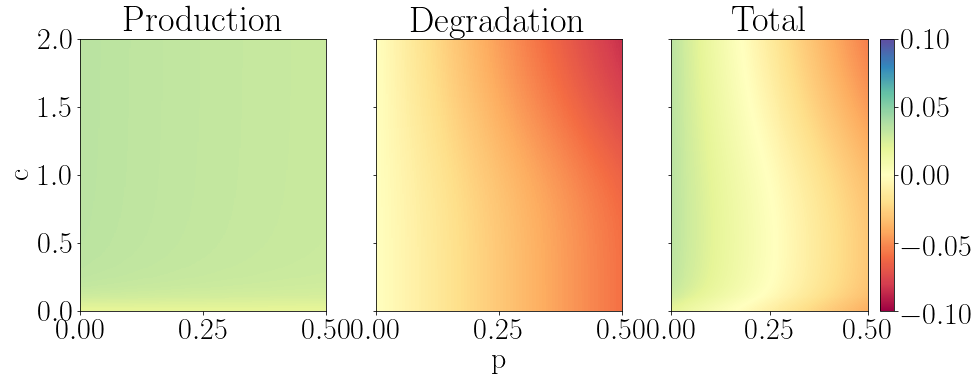

In [129]:
Gstar = 0.1
p, c = np.meshgrid(np.linspace(0, 0.5, 200), np.linspace(0, 2, 300))
p_prod = ip3_production(Gstar, c, p)
p_deg = ip3_degradation(c, p)

fig, ax = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(15, 5))

ax[0].pcolormesh(p, c, p_prod, cmap='Spectral', vmax=0.1, vmin=-0.1)
ax[1].pcolormesh(p, c, -p_deg, cmap='Spectral', vmax=0.1, vmin=-0.1)
cbar = ax[2].pcolormesh(p, c, p_prod - p_deg, cmap='Spectral', vmax=0.1, vmin=-0.1)

ax[0].set_title('Production')
ax[1].set_title('Degradation')
ax[2].set_title('Total')

fig.colorbar(cbar, ax=ax[2])

ax[1].set_xlabel('p')
ax[0].set_ylabel('c')

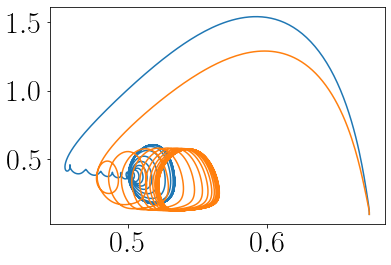

In [185]:
input_max = 0.15
input_duration = 500
t_f = 500
run_Gstar_controlled_experiment('pulse', t_f=t_f)
plt.plot(h, c)

input_max = 0.1
run_Gstar_controlled_experiment('pulse', t_f=t_f)
plt.plot(h, c)


# Animations of p/c system against bifurcation

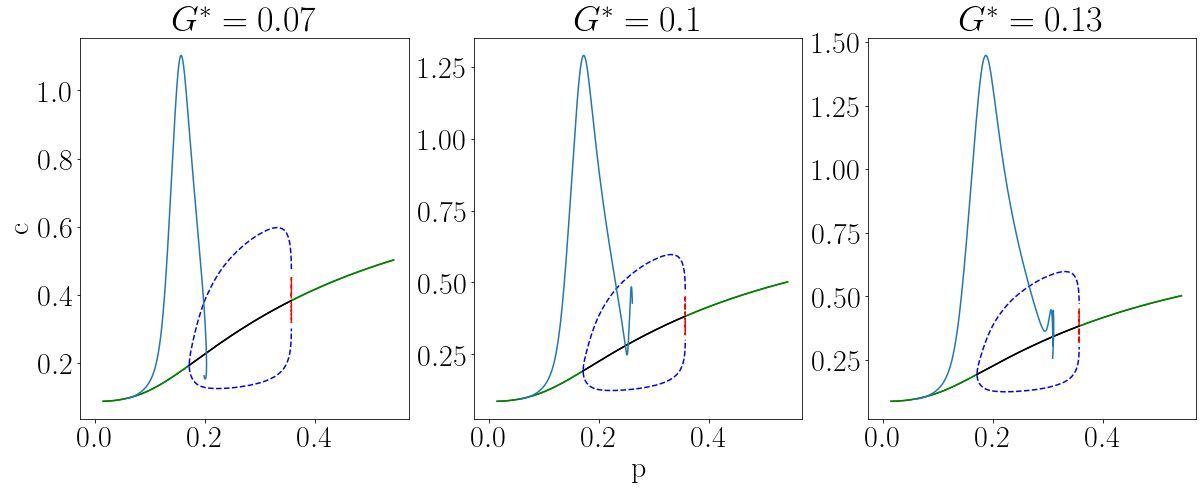

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(20,7))

input_max = 0.1
input_duration = 300
t_fs = [40, 50, 100]
Gstars = [0.07, 0.1, 0.13]


for i, input_max in enumerate(Gstars):
    plot_bifurcation('ip3_ca.dat', ax=ax[i])
    run_Gstar_controlled_experiment('pulse', t_f=t_fs[i])
    ax[i].plot(p, c)
    ax[i].set_title(r'$G^* = ' + str(input_max) + '$')

ax[1].set_xlabel('p')
ax[0].set_ylabel('c')

input_max = 0.1
input_duration = 50

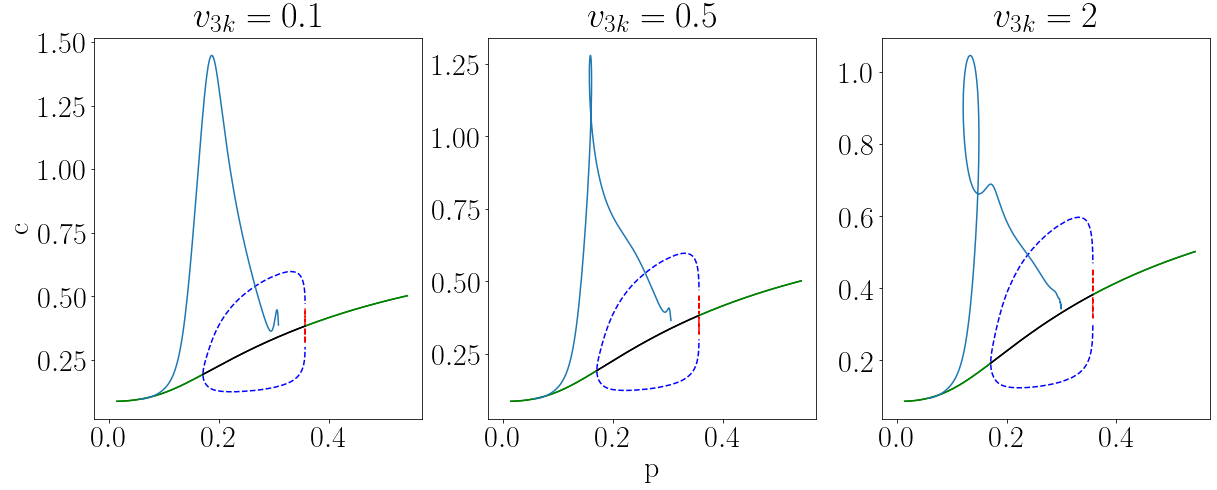

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(20,7))

input_max = 0.13
input_duration = 300
t_fs = [50, 60, 130]
v_3ks = [0.1, 0.5, 2]


for i, v_3k in enumerate(v_3ks):
    plot_bifurcation('ip3_ca.dat', ax=ax[i])
    run_Gstar_controlled_experiment('pulse', t_f=t_fs[i])
    ax[i].plot(p, c)
    ax[i].set_title(r'$v_{3k} = ' + str(v_3k) + '$')

ax[1].set_xlabel('p')
ax[0].set_ylabel('c')

input_max = 0.1
input_duration = 50

## Animations in v_3k, G* = 0.13

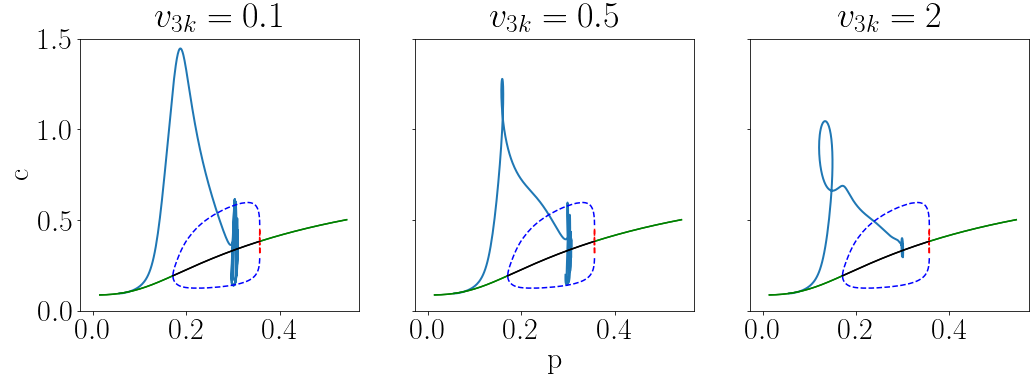

In [74]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5), sharex=True, sharey=True)

lines = []
cs = []
ps = []
input_max = 0.13
input_duration = 300
t_fs = [50, 60, 130]
v_3ks = [0.1, 0.5, 2]

ax[i].set_ylim([0, 1.5])
ax[1].set_xlabel('p')
ax[0].set_ylabel('c')

#initiate lines and solve ODEs
for i, v_3k in enumerate(v_3ks):
    lines.append(ax[i].plot([], [], lw=2)[0])
    plot_bifurcation('ip3_ca.dat', ax=ax[i])
    run_Gstar_controlled_experiment('pulse', t_f = 300)
    ax[i].set_title(r'$v_{3k} = ' + str(v_3k) + '$')

    cs.append(c)
    ps.append(p)
    
    
# line, = ax[0].plot([], [], lw=2)

def init():
    for i in range(3):
        lines[i].set_data([], [])
    return lines

def animate(i):
    for j in range(3):
        lines[j].set_data(ps[j][:i*10], cs[j][:i*10])
    return lines


anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)
HTML(anim.to_html5_video())


## Animations in G*

### With v_3k = 0.1

In [3]:
!brew install imagemagick

'brew' is not recognized as an internal or external command,
operable program or batch file.


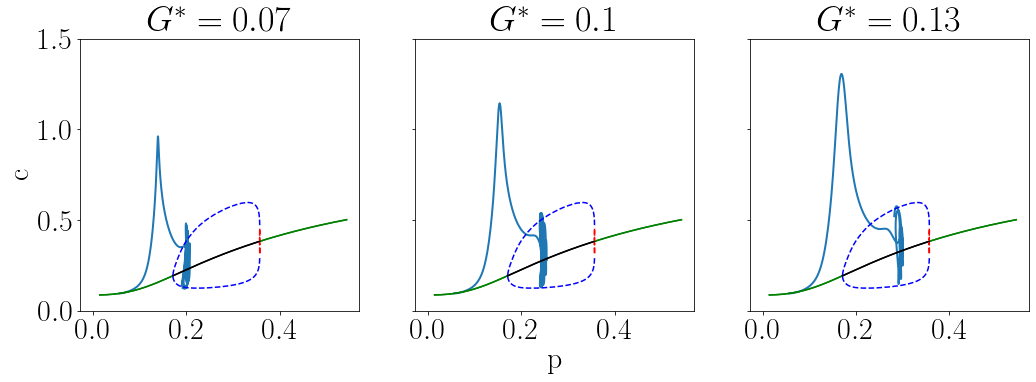

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5), sharex=True, sharey=True)

lines = []
cs = []
ps = []
input_max = 0.13
input_duration = 300
t_fs = [50, 60, 130]
Gstars = [0.07, 0.1, 0.13]
v_3k = 0.1

ax[1].set_ylim([0, 1.5])
ax[1].set_xlabel('p')
ax[0].set_ylabel('c')

#initiate lines and solve ODEs
for i, input_max in enumerate(Gstars):
    lines.append(ax[i].plot([], [], lw=2)[0])
    plot_bifurcation('ip3_ca.dat', ax=ax[i])
    run_Gstar_controlled_experiment('pulse', t_f = 300)
    ax[i].set_title(r'$G^* = ' + str(input_max) + '$')

    cs.append(c)
    ps.append(p)
    
    
# line, = ax[0].plot([], [], lw=2)

def init():
    for i in range(3):
        lines[i].set_data([], [])
    return lines

def animate(i):
    for j in range(3):
        lines[j].set_data(ps[j][:i*10], cs[j][:i*10])
    return lines


anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)
HTML(anim.to_html5_video())


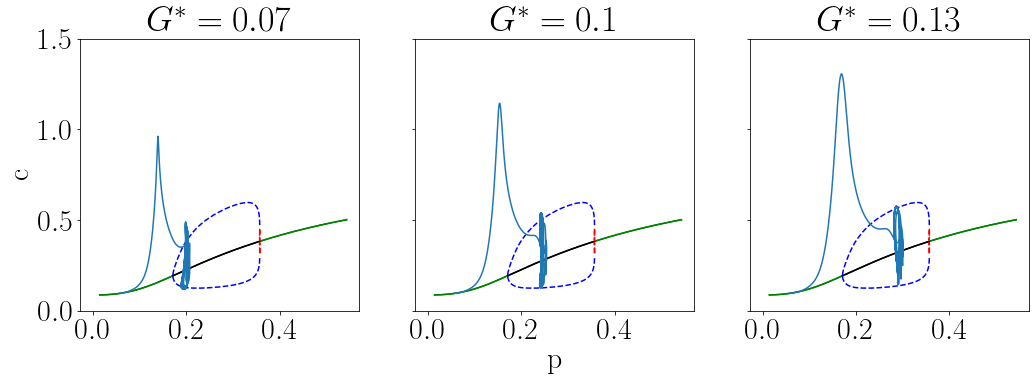

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5), sharex=True, sharey=True)

lines = []
cs = []
ps = []
input_max = 0.13
input_duration = 300
t_fs = [50, 60, 130]
Gstars = [0.07, 0.1, 0.13]
v_3k = 0.1

ax[1].set_ylim([0, 1.5])
ax[1].set_xlabel('p')
ax[0].set_ylabel('c')

# #initiate lines and solve ODEs
# for i, input_max in enumerate(Gstars):
#     lines.append(ax[i].plot([], [], lw=2)[0])
#     plot_bifurcation('ip3_ca.dat', ax=ax[i])
#     run_Gstar_controlled_experiment('pulse', t_f = 300)
#     ax[i].set_title(r'$G^* = ' + str(input_max) + '$')

#     cs.append(c)
#     ps.append(p)
        
# def init():
#     for i in range(3):
#         lines[i].set_data([], [])
#     return lines

# def animate(i):
#     for j in range(3):
#         lines[j].set_data(ps[j][:i*10], cs[j][:i*10])
#     return lines


# anim = animation.FuncAnimation(fig, animate, init_func=init,
#                                frames=200, interval=20, blit=True)

# HTML(anim.to_html5_video())
# anim.save('figures/Gstar_bifurcation_trajectories.mp4')

for i, input_max in enumerate(Gstars):
    lines.append(ax[i].plot([], [], lw=2)[0])
    plot_bifurcation('ip3_ca.dat', ax=ax[i])
    run_Gstar_controlled_experiment('pulse', t_f = 300)
    ax[i].set_title(r'$G^* = ' + str(input_max) + '$')
    ax[i].plot(p, c, c=color_cycle[0])

fig.savefig('figures/trajectories_on_bifurcation_p_c.png', bbox_inches='tight')

# 2D Bifurcation

Looking here at 2D bifurcations in other variables

## Gstar, c_tot

With c_total treated as a parameter instead of variable, observe that oscillations disappear for certain values of c_tot

Based on this, it looks like c_tot does not explain the delays, as even though c_total is very similar when v_3k is on or off, delays are still seen when v_3k is on

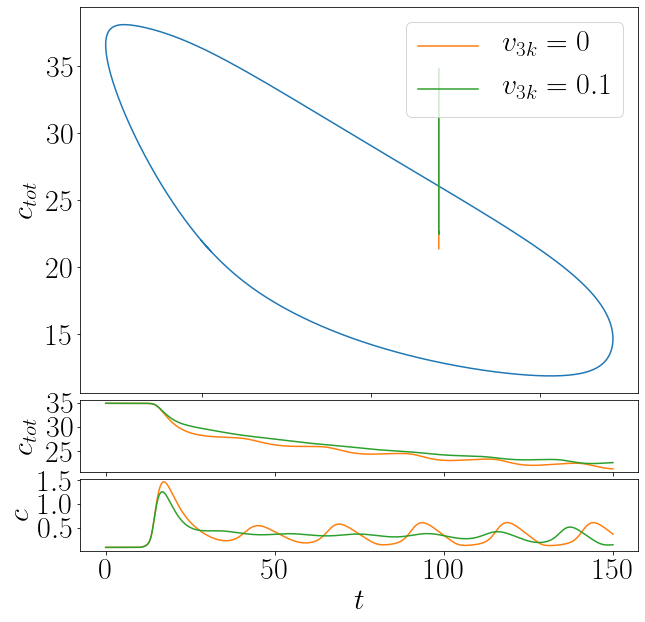

In [28]:
data = load_data('Gstar_ctot.dat')

v_3ks = [0, 0.1]
input_max = 0.12
input_duration = 300
plot_length = 1500

fig = plt.figure(figsize=(10,10))
spec = gridspec.GridSpec(14, 1, figure=fig)

ax1 = fig.add_subplot(spec[:10, 0])
ax2 = fig.add_subplot(spec[10:12, 0])
ax3 = fig.add_subplot(spec[12:, 0])

ax1.plot(data[0], data[1])

ax1.set_xlabel('$G^*$')
ax1.set_ylabel('$c_{tot}$')
ax2.set_ylabel('$c_{tot}$')
ax3.set_xlabel('$t$')
ax3.set_ylabel('$c$')
for i, v_3k in enumerate(v_3ks):
    run_Gstar_controlled_experiment('pulse', t_f=300)

    traj = c_tot[:plot_length]
    ax1.plot(np.full(len(traj), input_max), traj, c=color_cycle[i+1], label='$v_{3k}=' + str(v_3k) + '$')
    ax2.plot(t[:plot_length], traj, c=color_cycle[i+1])
    ax3.plot(t[:plot_length], c[:plot_length], c=color_cycle[i+1])

ax1.legend()

# Looking at trajectories with positive negative on/off

* Delays can occur with positive and negative feedback turned off when c_tot is dynamic
* Delays can occur with c_tot fixed, but negative must be on
* Positive on does not matter for delays
* Delays only happen for sufficiently large G* (dependent on parameters)


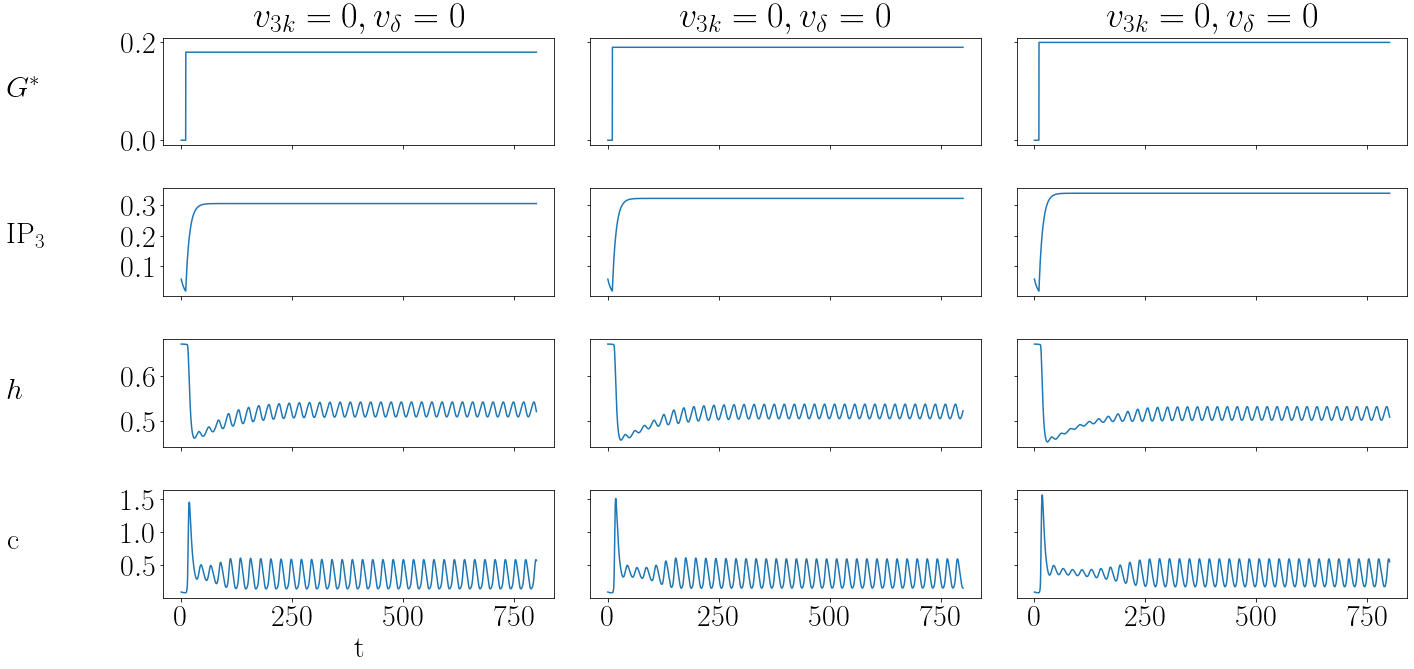

In [63]:
t_f = 800
input_duration = t_f
input_max = 0.15
v_3ks = [0, 0, 0]
v_deltas = [0, 0, 0]
Gstars = [0.18, 0.19, 0.20]

fig, ax = plt.subplots(4, len(v_3ks), sharex=True, sharey='row', figsize=(20, 10))

for i, v_3k in enumerate(v_3ks):
    input_max = Gstars[i]
    v_delta = v_deltas[i]
    run_Gstar_controlled_experiment('pulse', t_f=t_f)

    #plot figures
    ax[0, i].plot(t_input, Gstar)
    ax[1, i].plot(t, p)
    ax[2, i].plot(t, h)
    ax[3, i].plot(t, c)

    ax[0, i].set_title(r'$v_{3k} = ' + str(v_3k) + ', v_{\delta}= ' + str(v_delta) + '$')

    
#set xlabel
ax[3, 0].set_xlabel('t')

#set ylabels
ax[0, 0].set_ylabel(r'$G^*$', rotation='horizontal', ha='left')
ax[1, 0].set_ylabel(r'IP$_3$', rotation='horizontal', ha='left')
ax[2, 0].set_ylabel(r'$h$', rotation='horizontal', ha='left')
ax[3, 0].set_ylabel(r'c', rotation='horizontal', ha='left')

#align ylabels
ax[0, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[1, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[2, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[3, 0].get_yaxis().set_label_coords(-0.4,0.4)

fig.tight_layout()

## $c_{tot}$ fixed, positive or negative on

Here we see that when $c_{tot}$ is fixed, negative feedback must be on to have delays

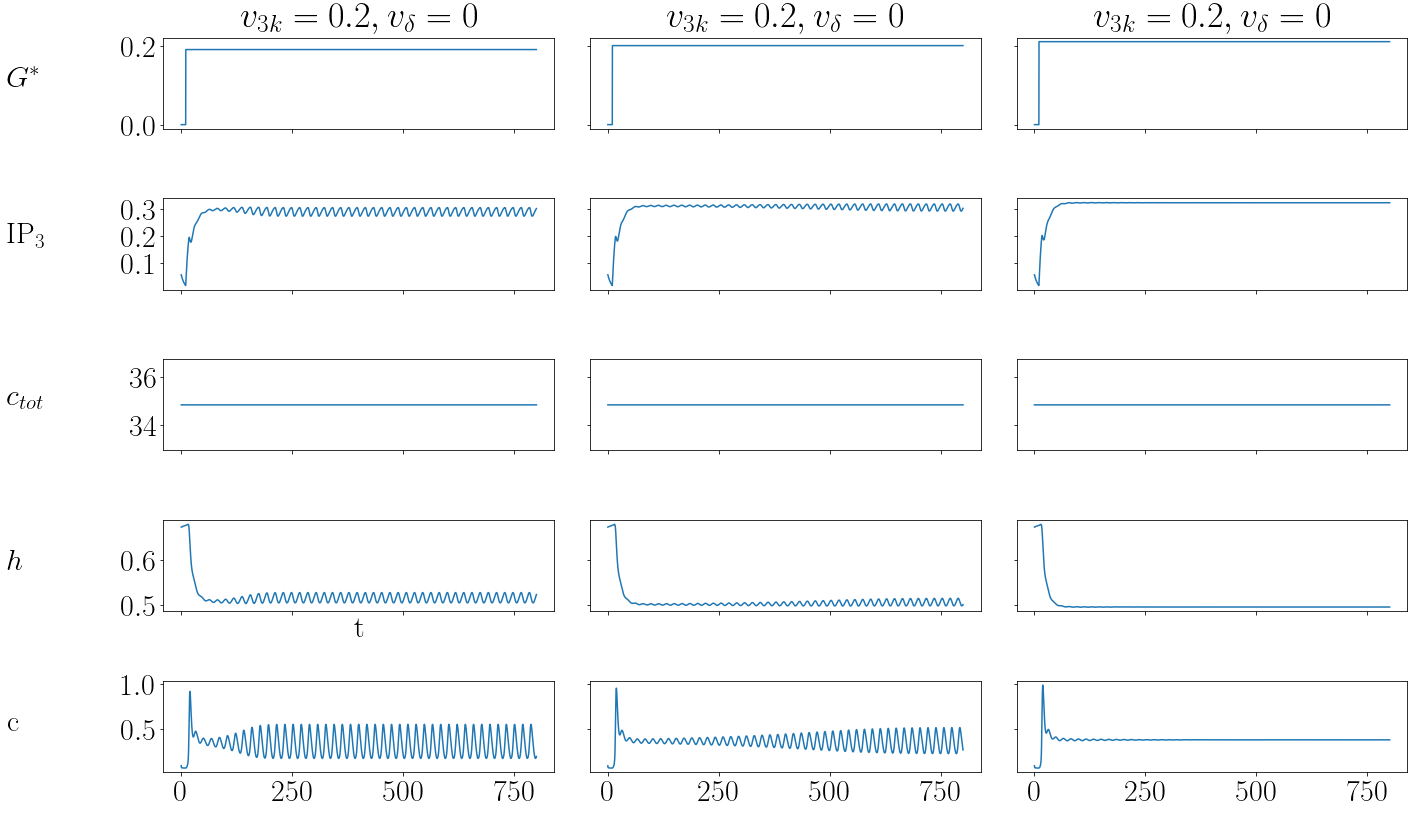

In [57]:
t_f = 800
input_duration = t_f
input_max = 0.15
v_3ks = [0.2, 0.2, 0.2]
v_deltas = [0, 0, 0]

Gstars = [0.19, 0.2, 0.21]

fig, ax = plt.subplots(5, len(v_3ks), sharex=True, sharey='row', figsize=(20, 12))

for i, v_3k in enumerate(v_3ks):
    v_delta = v_deltas[i]
    input_max = Gstars[i]
    run_Gstar_controlled_experiment('pulse', t_f=t_f)

    #plot figures
    ax[0, i].plot(t_input, Gstar)
    ax[1, i].plot(t, p)
    ax[2, i].plot(t, c_tot)
    ax[3, i].plot(t, h)
    ax[4, i].plot(t, c)

    ax[0, i].set_title(r'$v_{3k} = ' + str(v_3k) + ', v_{\delta}= ' + str(v_delta) + '$')

    
#set xlabel
ax[3, 0].set_xlabel('t')

#set ylabels
ax[0, 0].set_ylabel(r'$G^*$', rotation='horizontal', ha='left')
ax[1, 0].set_ylabel(r'IP$_3$', rotation='horizontal', ha='left')
ax[2, 0].set_ylabel(r'$c_{tot}$', rotation='horizontal', ha='left')
ax[3, 0].set_ylabel(r'$h$', rotation='horizontal', ha='left')
ax[4, 0].set_ylabel(r'c', rotation='horizontal', ha='left')

#align ylabels
ax[0, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[1, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[2, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[3, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[4, 0].get_yaxis().set_label_coords(-0.4,0.4)

fig.tight_layout()

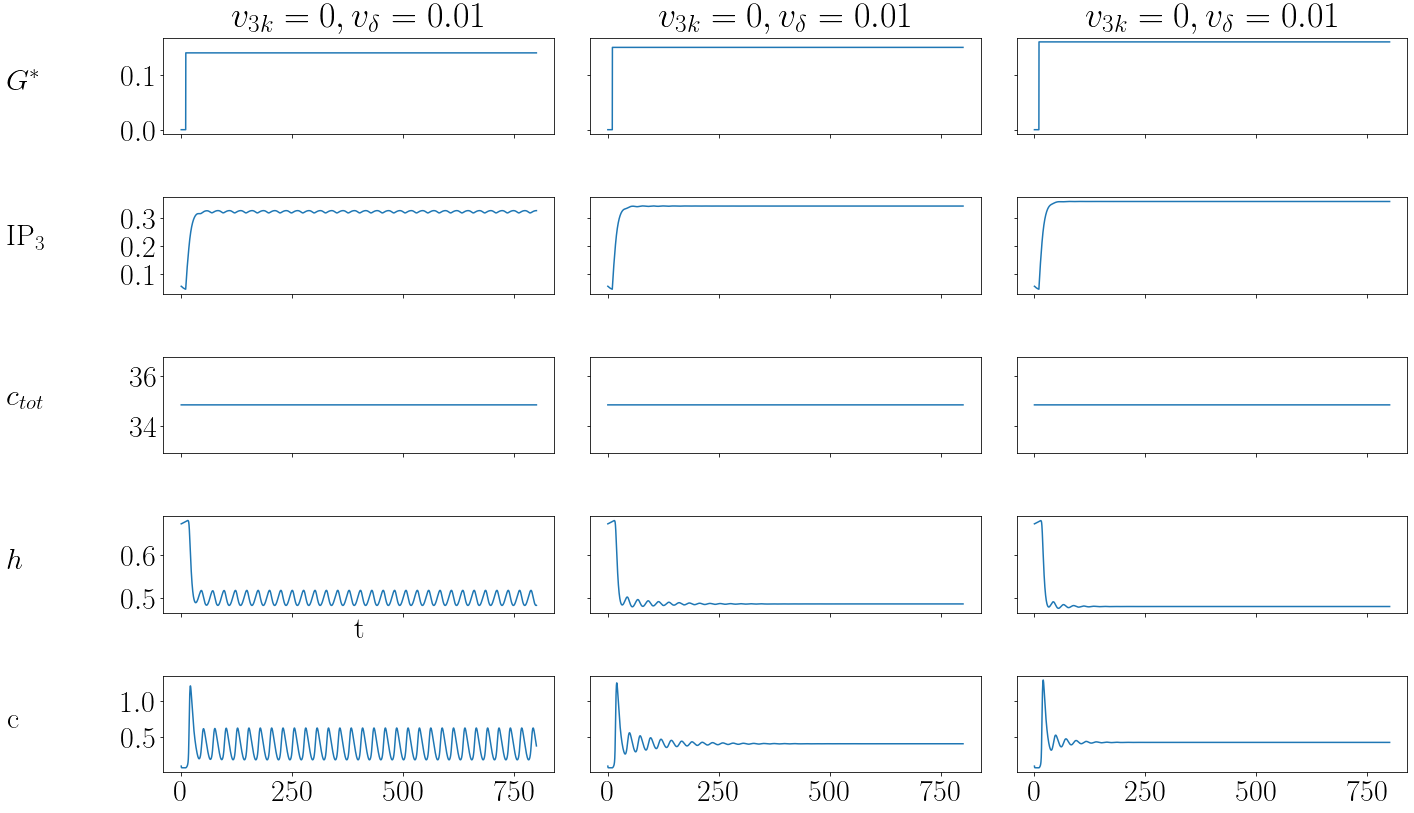

In [56]:
t_f = 800
input_duration = t_f
input_max = 0.15
v_3ks = [0, 0, 0]
v_deltas = [0.01, 0.01, 0.01]

Gstars = [0.14, 0.15, 0.16]

fig, ax = plt.subplots(5, len(v_3ks), sharex=True, sharey='row', figsize=(20, 12))

for i, v_3k in enumerate(v_3ks):
    v_delta = v_deltas[i]
    input_max = Gstars[i]
    run_Gstar_controlled_experiment('pulse', t_f=t_f)

    #plot figures
    ax[0, i].plot(t_input, Gstar)
    ax[1, i].plot(t, p)
    ax[2, i].plot(t, c_tot)
    ax[3, i].plot(t, h)
    ax[4, i].plot(t, c)

    ax[0, i].set_title(r'$v_{3k} = ' + str(v_3k) + ', v_{\delta}= ' + str(v_delta) + '$')

    
#set xlabel
ax[3, 0].set_xlabel('t')

#set ylabels
ax[0, 0].set_ylabel(r'$G^*$', rotation='horizontal', ha='left')
ax[1, 0].set_ylabel(r'IP$_3$', rotation='horizontal', ha='left')
ax[2, 0].set_ylabel(r'$c_{tot}$', rotation='horizontal', ha='left')
ax[3, 0].set_ylabel(r'$h$', rotation='horizontal', ha='left')
ax[4, 0].set_ylabel(r'c', rotation='horizontal', ha='left')

#align ylabels
ax[0, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[1, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[2, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[3, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[4, 0].get_yaxis().set_label_coords(-0.4,0.4)

fig.tight_layout()

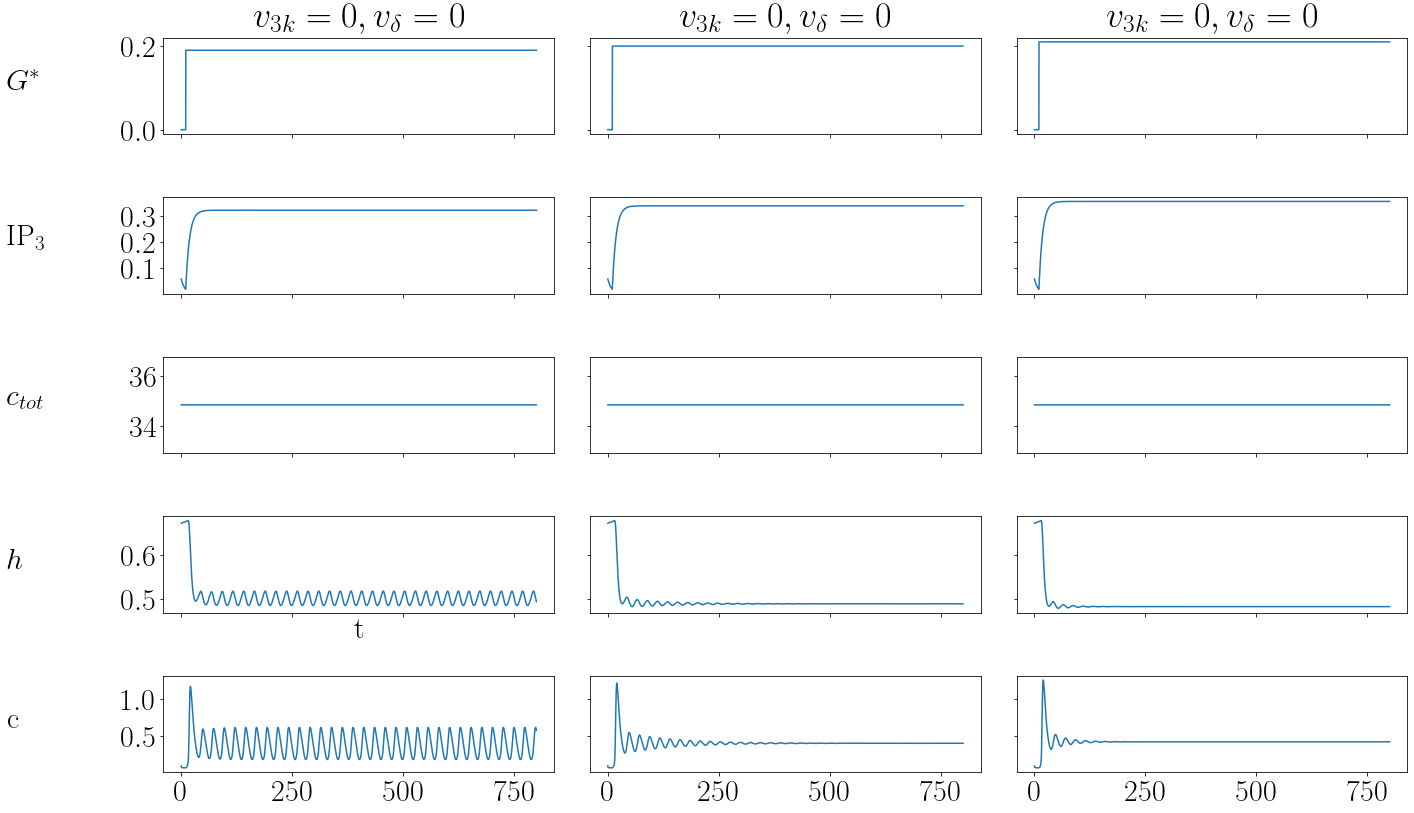

In [59]:
t_f = 800
input_duration = t_f
input_max = 0.15
v_3ks = [0, 0, 0]
v_deltas = [0, 0, 0]

Gstars = [0.19, 0.2, 0.21]

fig, ax = plt.subplots(5, len(v_3ks), sharex=True, sharey='row', figsize=(20, 12))

for i, v_3k in enumerate(v_3ks):
    v_delta = v_deltas[i]
    input_max = Gstars[i]
    run_Gstar_controlled_experiment('pulse', t_f=t_f)

    #plot figures
    ax[0, i].plot(t_input, Gstar)
    ax[1, i].plot(t, p)
    ax[2, i].plot(t, c_tot)
    ax[3, i].plot(t, h)
    ax[4, i].plot(t, c)

    ax[0, i].set_title(r'$v_{3k} = ' + str(v_3k) + ', v_{\delta}= ' + str(v_delta) + '$')

    
#set xlabel
ax[3, 0].set_xlabel('t')

#set ylabels
ax[0, 0].set_ylabel(r'$G^*$', rotation='horizontal', ha='left')
ax[1, 0].set_ylabel(r'IP$_3$', rotation='horizontal', ha='left')
ax[2, 0].set_ylabel(r'$c_{tot}$', rotation='horizontal', ha='left')
ax[3, 0].set_ylabel(r'$h$', rotation='horizontal', ha='left')
ax[4, 0].set_ylabel(r'c', rotation='horizontal', ha='left')

#align ylabels
ax[0, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[1, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[2, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[3, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[4, 0].get_yaxis().set_label_coords(-0.4,0.4)

fig.tight_layout()

# Bifurcation in other variables

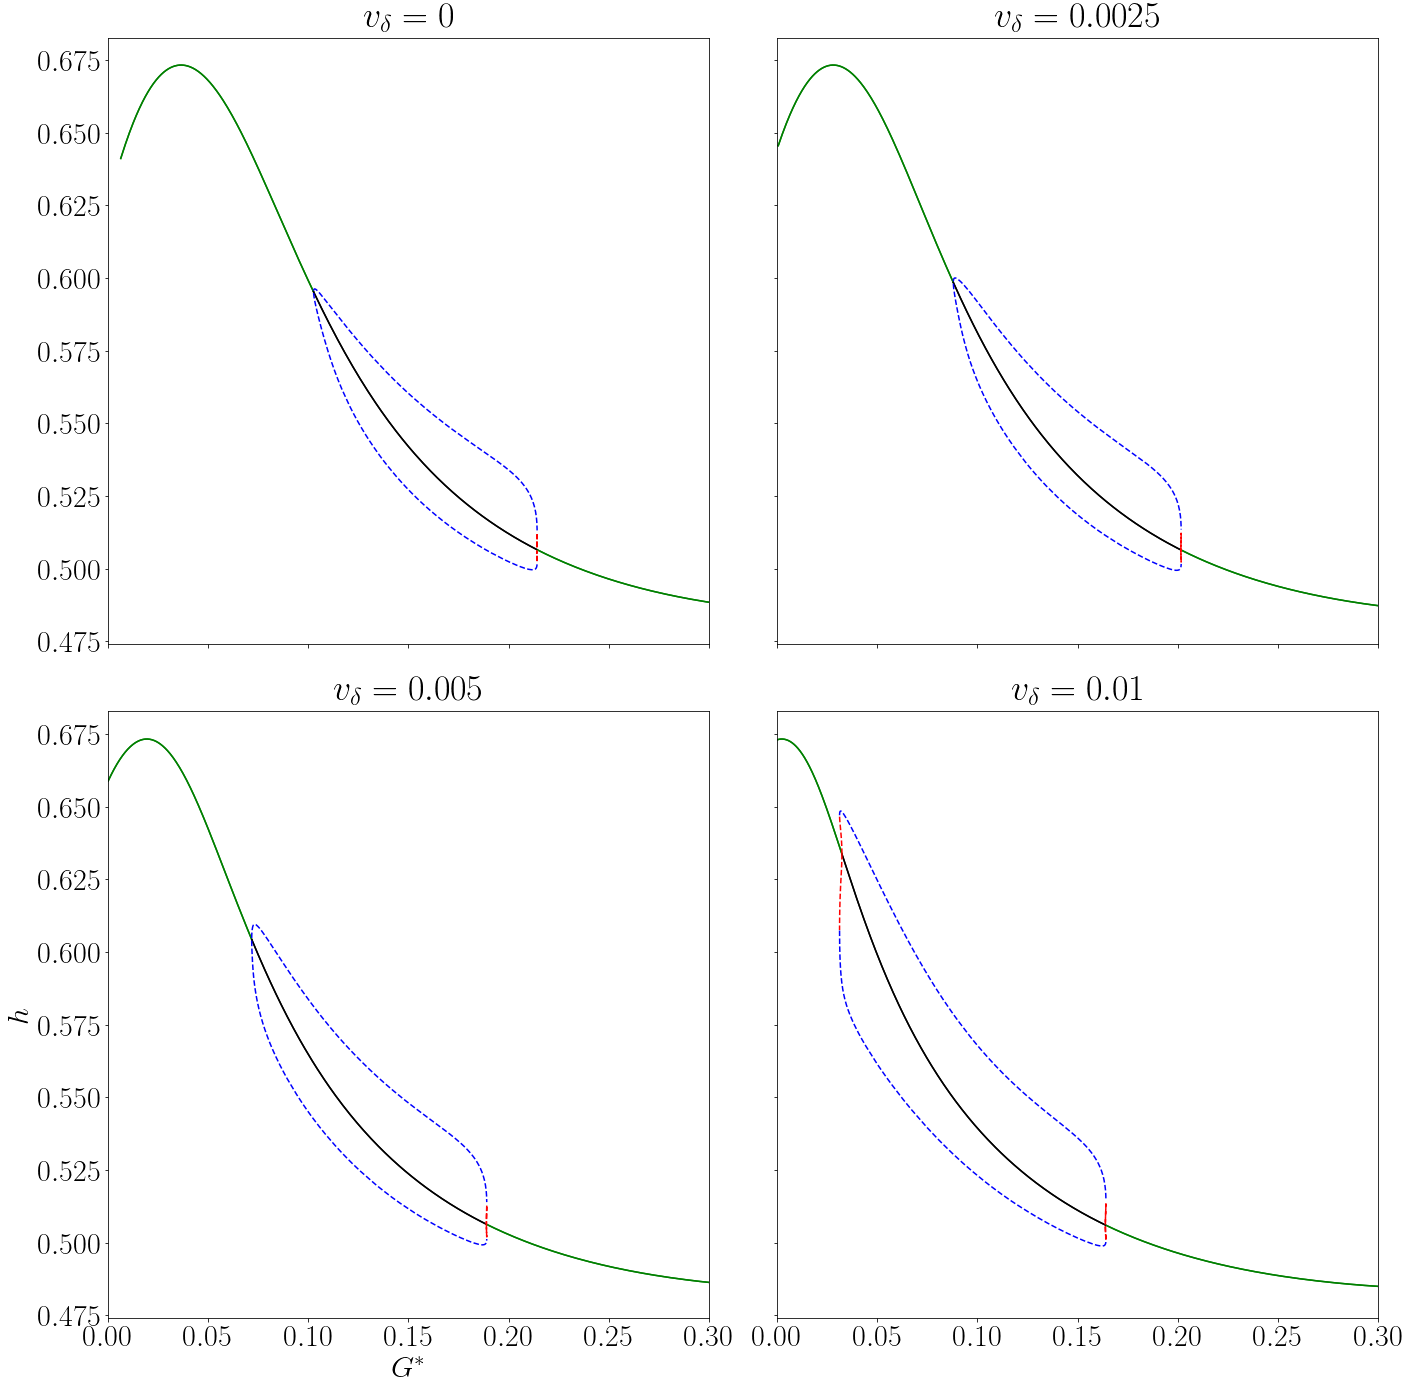

In [6]:
rows = 2
cols = 2
fig, ax = plt.subplots(rows, cols, figsize=(20, 20), sharex=True, sharey=True)

v_deltas = [0, 0.0025, 0.005, 0.01]

for i, vdelta in enumerate(v_deltas):
    ax_i = int(np.floor(i / rows))
    ax_j = i % cols
    plot_bifurcation('h_Gstar_v3k_0_vdelta_' + str(vdelta) + '.dat', ax[ax_i][ax_j])
    ax[ax_i][ax_j].set_title(r'$v_{\delta}=' + str(vdelta) + '$')

ax[1,0].set_ylabel(r'$h$')
ax[1,0].set_xlabel(r'$G^*$')
ax[1,0].set_xlim([0, 0.3])
plt.tight_layout()



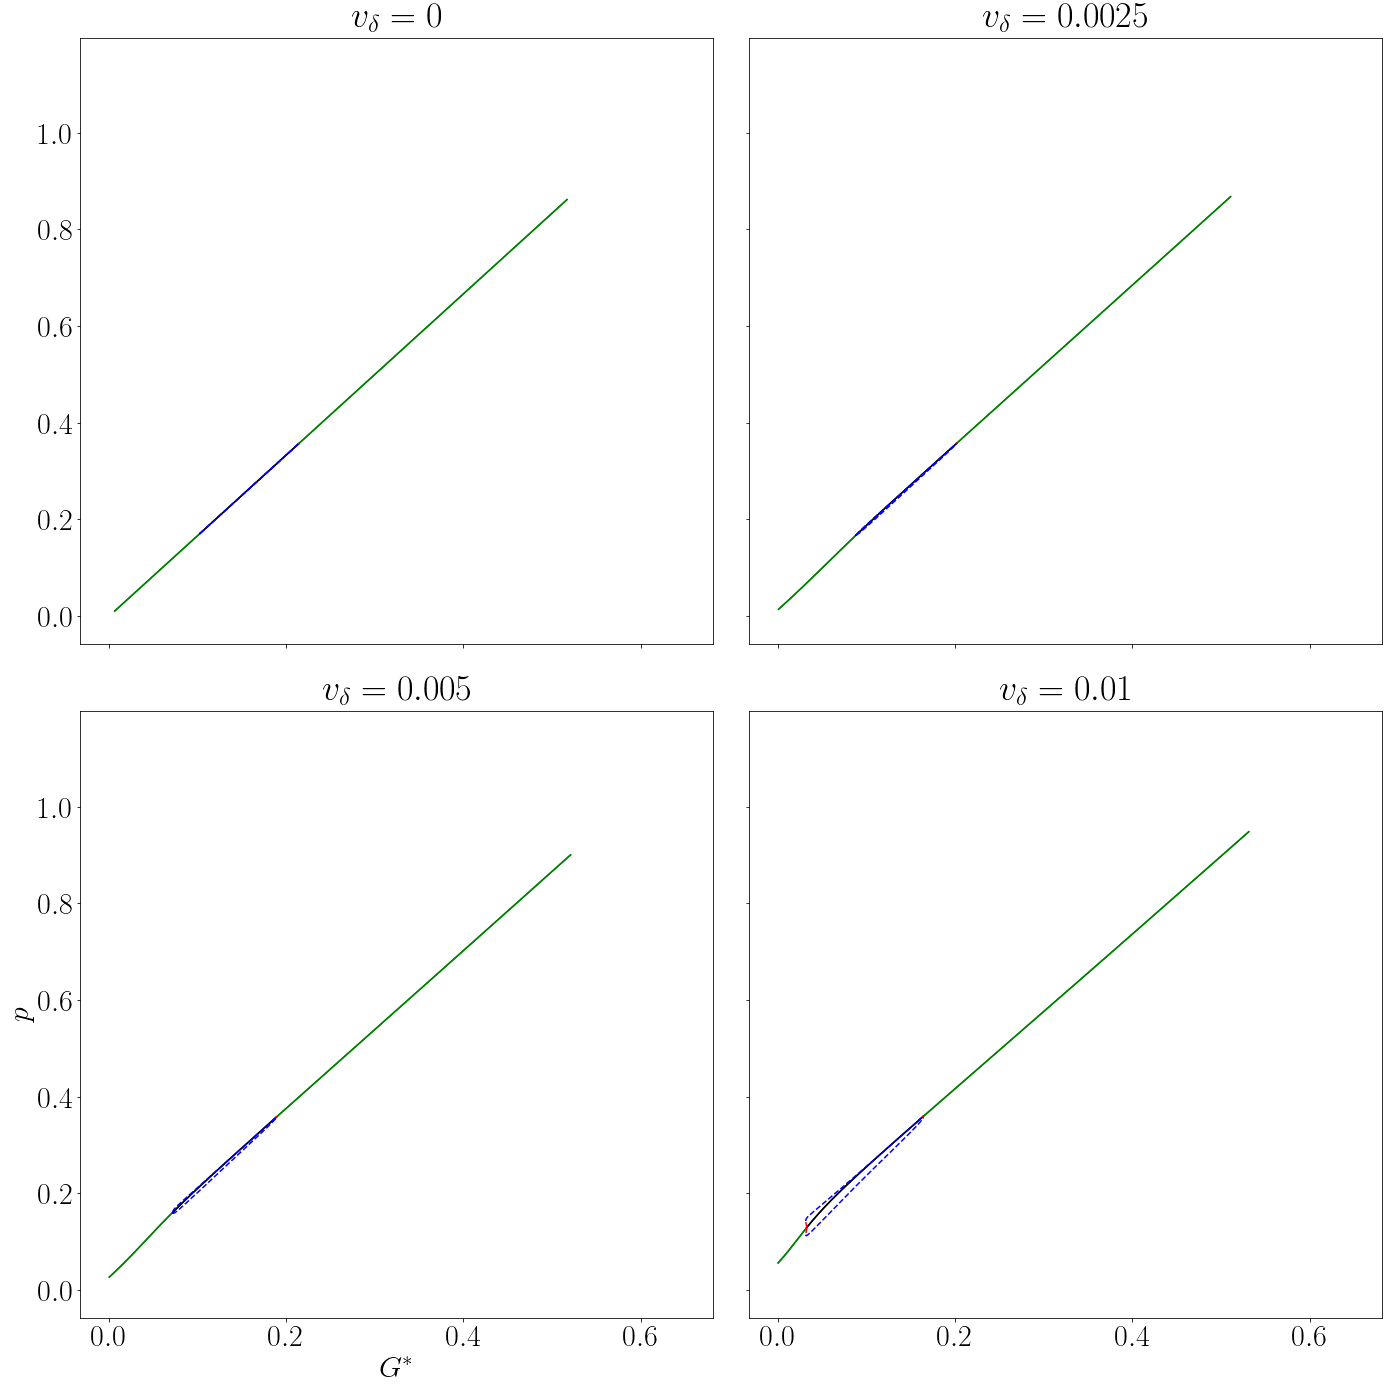

In [23]:
rows = 2
cols = 2
fig, ax = plt.subplots(rows, cols, figsize=(20, 20), sharex=True, sharey=True)

v_deltas = [0, 0.0025, 0.005, 0.01]

for i, vdelta in enumerate(v_deltas):
    ax_i = int(np.floor(i / rows))
    ax_j = i % cols
    plot_bifurcation('p_Gstar_v3k_0_vdelta_' + str(vdelta) + '.dat', ax[ax_i][ax_j])
    ax[ax_i][ax_j].set_title(r'$v_{\delta}=' + str(vdelta) + '$')

ax[1,0].set_ylabel(r'$p$')
ax[1,0].set_xlabel(r'$G^*$')

plt.tight_layout()



---

# Bifurcations with GPCR

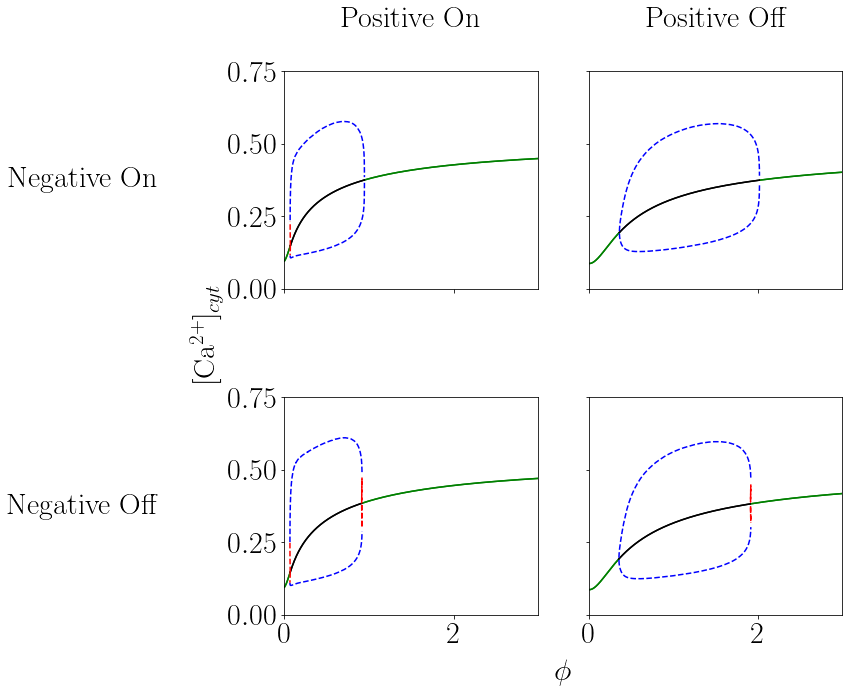

In [7]:
filenames = ['v3k_0.1_vdelta_0.01', 'v3k_0.1_vdelta_0', 'v3k_0_vdelta_0.01', 'v3k_0_vdelta_0']
titles = ['base', 'no +', 'no -', 'no +, no -']
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)


for i in range(2):
    for j in range(2):
        filename = filenames[i*2 + j]
        plot_bifurcation('c_glut_' + filename + '.dat', ax[i, j])
        
ax[0, 0].text(0.5, 1.2, 'Positive On', horizontalalignment='center', transform=ax[0, 0].transAxes)
ax[0, 1].text(0.5, 1.2, 'Positive Off', horizontalalignment='center', transform=ax[0, 1].transAxes)

ax[0, 0].text(-0.5, 0.5, 'Negative On', 
          verticalalignment='center', horizontalalignment='right', transform=ax[0, 0].transAxes)
ax[1, 0].text(-0.5, 0.5, 'Negative Off', 
          verticalalignment='center', horizontalalignment='right', transform=ax[1, 0].transAxes)

ax[1, 0].text(1.1, -0.3, r'$\phi$', horizontalalignment='center', transform=ax[1, 0].transAxes)
ax[1, 0].text(-0.3, 1.3, r'[Ca$^{2+}$]$_{cyt}$', rotation=90, transform=ax[1, 0].transAxes, 
              horizontalalignment='center', verticalalignment='center')

ax[0, 0].set_xlim([0, 3])
ax[0, 0].set_ylim([0, 0.75])


fig.subplots_adjust(hspace=0.5)
fig.savefig('figures/gpcr_positive_negative_bifurcations.png', bbox_inches='tight')

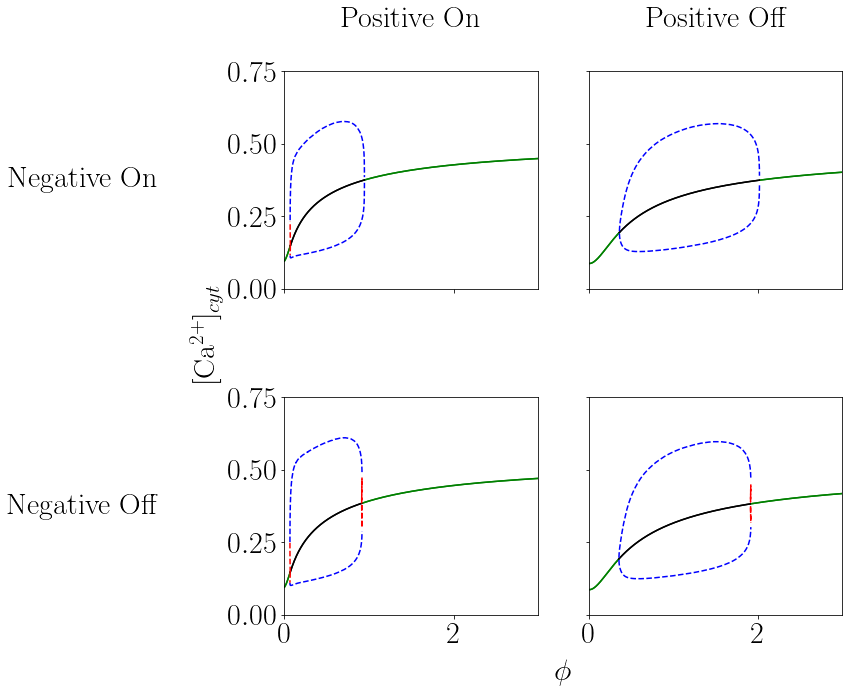

In [39]:
filenames = ['v3k_0.1_vdelta_0.01', 'v3k_0.1_vdelta_0', 'v3k_0_vdelta_0.01', 'v3k_0_vdelta_0']
titles = ['base', 'no +', 'no -', 'no +, no -']
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)


for i in range(2):
    for j in range(2):
        filename = filenames[i*2 + j]
        plot_bifurcation('c_glut_' + filename + '.dat', ax[i, j])
        
ax[0, 0].text(0.5, 1.2, 'Positive On', horizontalalignment='center', transform=ax[0, 0].transAxes)
ax[0, 1].text(0.5, 1.2, 'Positive Off', horizontalalignment='center', transform=ax[0, 1].transAxes)

ax[0, 0].text(-0.5, 0.5, 'Negative On', 
          verticalalignment='center', horizontalalignment='right', transform=ax[0, 0].transAxes)
ax[1, 0].text(-0.5, 0.5, 'Negative Off', 
          verticalalignment='center', horizontalalignment='right', transform=ax[1, 0].transAxes)

ax[1, 0].text(1.1, -0.3, r'$\phi$', horizontalalignment='center', transform=ax[1, 0].transAxes)
ax[1, 0].text(-0.3, 1.3, r'[Ca$^{2+}$]$_{cyt}$', rotation=90, transform=ax[1, 0].transAxes, 
              horizontalalignment='center', verticalalignment='center')

ax[0, 0].set_xlim([0, 3])
ax[0, 0].set_ylim([0, 0.75])


fig.subplots_adjust(hspace=0.5)
fig.savefig('figures/gpcr_positive_negative_bifurcations.png', bbox_inches='tight')

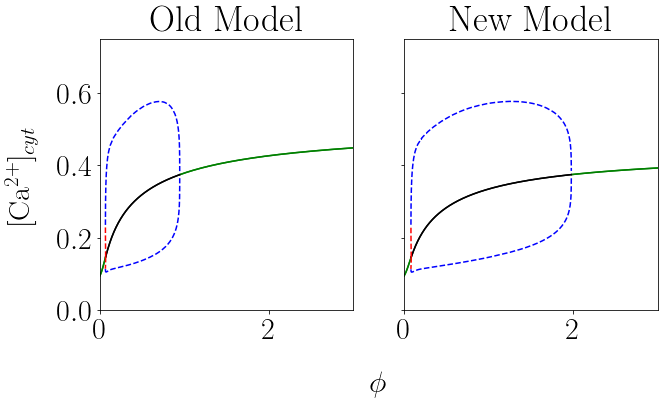

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

# plt.figure(figsize=(10,5))
data = plot_bifurcation('c_glut_v3k_0.1_vdelta_0.01.dat', ax[0], ret=True, increasing=True)
# ax[0].set_xlabel('$\phi$')
# ax[0].set_ylabel('c')
plt.xlim([0, 3])
plt.ylim([0, 0.75])

plot_bifurcation('c_lambda.dat', ax[1], ret=False)

ax[0].text(1.1, -0.3, r'$\phi$', horizontalalignment='center', transform=ax[0].transAxes)
ax[0].text(-0.3, 0.5, r'[Ca$^{2+}$]$_{cyt}$', rotation=90, transform=ax[0].transAxes, 
              horizontalalignment='center', verticalalignment='center')

ax[0].set_title('Old Model')
ax[1].set_title('New Model')

plt.savefig('figures/c_glut_bifurcation_new.png', bbox_inches='tight')

In [6]:
d = data[data[3] == 1]

In [11]:
np.where(np.abs(d[0].diff()) > 0.01)

(array([618], dtype=int64),)